# Data Analysis
Notebook to analyse the paraphrasing data generated by this repo.


In [2]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import sys, os
import re

sys.path.append('../')

from src.utils import load_config, split_into_sentences, flatten_list
from src import stats_analysis as sa
from src.similarity_metrics import add_vectors_do_dataframe

from src.semantic_density import cluster_density_score, embeddings_trajectory_score,compute_mean_dtw_distance, dimensionality_reduction_score, regression_coef_density_score, compute_density_RFE_selection_score
from src.semantic_density import features_methods, cluster_methods, regression_methods, reduction_methods

[nltk_data] Downloading package punkt to /home/robin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


original dat length : 24 000
remove link : 23125
more than 20 sentences : 22953
remove when parpahrase happen in the 2 last sentences : 22444 stories


In [3]:
##
def encode_temperature(temperature):
    if temperature <2 :
        return "low"
    elif temperature <4 :
        return "medium"
    else : 
        return "high"



config = load_config('../config.yaml')


data = pd.read_pickle(config['agg_file'])
data['temperature_enc'] = data['temperature'].apply(encode_temperature)
data = data.reset_index(drop=True)
print(f"There are {len(data)} sample in pour dataset")

#data["clean_text"] = data.apply(lambda x: x.altered_text if type(x.text) != str else x.text, axis=1)
#data['sentences'] = data.apply(lambda x: split_into_sentences(x.clean_text), axis=1)
#data['num_sentences'] = data.apply(lambda x: len(x.sentences), axis=1)
data.sample(10).head(2)


There are 18039 sample in pour dataset


prompt  \
5924                     Today I am feeling   
2332  The thing I like most in the world is   

                                         generated_text model_name  \
5924  Today I am feeling better than when I started ...     pythia   
2332  The thing I like most in the world is my famil...       gpt2   

      temperature  num_beams  \
5924     2.516123          5   
2332     2.807022          4   

                                                   text llm_model  \
5924  Today I am feeling better than when I started ...    pythia   
2332  The thing I like most in the world is my famil...      gpt2   

     paraphrase_model                                       altered_text  \
5924               -1  Today I am feeling better than when I started ...   
2332               -1  The thing I like most in the world is my famil...   

      nb_paraphrase_max  ... reduction_score_PCA_explained_variance  \
5924                  0  ...                               0.426960   
2332                  0  ...                               0.456812   

     reduction_score_PCA_prop_of_components  cluster_density_score_HDBSCAN  \
5924                               0.333333                       0.428571   
2332                               0.285714                       0.375000   

      cluster_reverse_silhouette_score_HDBSCAN  \
5924                                  0.936665   
2332                                  0.943004   

      cluster_density_score_MeanShift  \
5924                         0.571429   
2332                         0.250000   

      cluster_reverse_silhouette_score_MeanShift  \
5924                                    0.978312   
2332                                    0.861133   

     regression_coef_density_score_Lasso  regression_error_score_Lasso  \
5924                            0.857143                      0.285825   
2332                            0.625000                      0.332948   

      reduction_score_Lasso  temperature_enc  
5924               0.714286           medium  
2332               0.750000           medium  

[2 rows x 133 columns]

<Axes: xlabel='num_sentences', ylabel='model_name'>

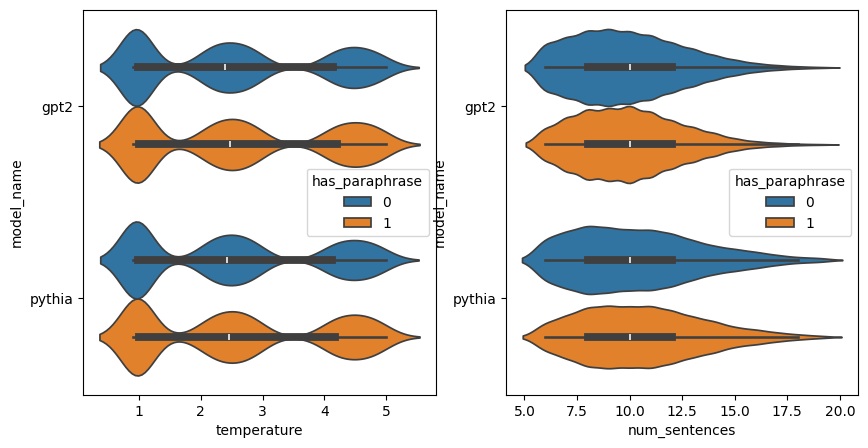

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
sns.violinplot(data = data, x="temperature", y ="model_name", hue="has_paraphrase", ax = axes[0])
sns.violinplot(data = data, x="num_sentences", y ="model_name", hue="has_paraphrase", ax = axes[1])


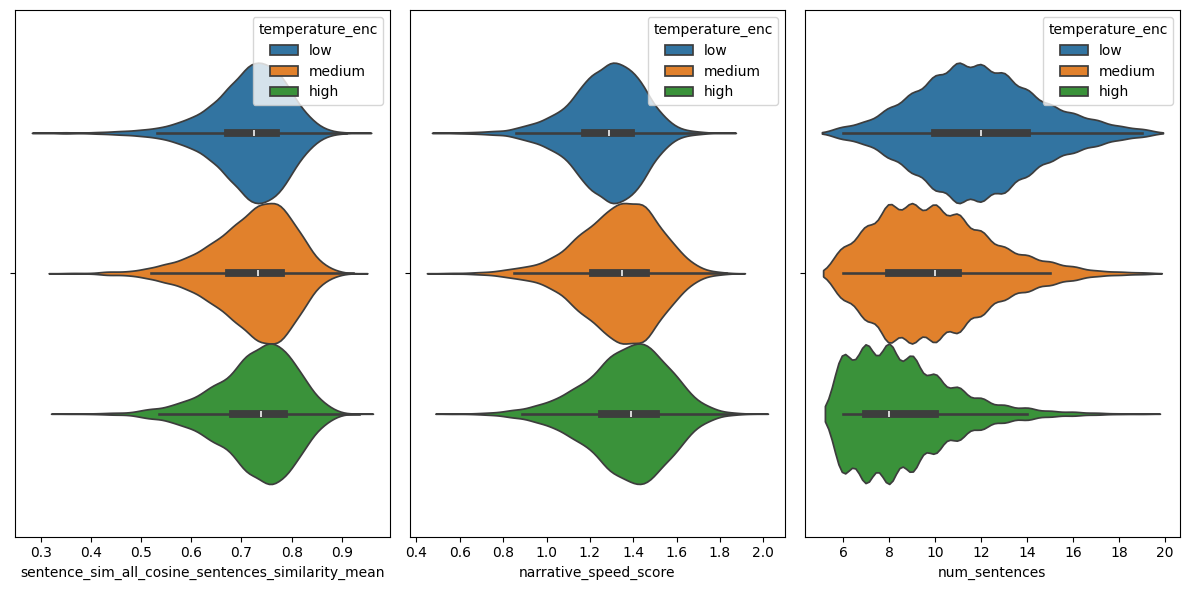

In [9]:
# Creating the figure and the axes
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

# Plotting the first violin plot for similarity_mean
sns.violinplot(
    ax=axes[0],
    x='sentence_sim_all_cosine_sentences_similarity_mean',
    hue='temperature_enc',
    data=data,
)

# Plotting the second violin plot for narrative_speed_score
sns.violinplot(
    ax=axes[1],
    x='narrative_speed_score',
    hue='temperature_enc',
    data=data,
)

# Plotting the third violin plot for num_sentences
sns.violinplot(
    ax=axes[2],
    x='num_sentences',
    data=data,
    hue='temperature_enc',

)

# Adjusting layout and showing the plot
plt.tight_layout()
plt.show()

In [5]:
def plot_para_vs_others_temperature(with_paraphrase, para_model):
    diff_low = pd.DataFrame()
    diff_medium = pd.DataFrame()
    diff_high = pd.DataFrame()
    model_low = []
    model_medium = []
    model_high = []
    para_vs_others_low=  []
    para_vs_others_medium = []
    para_vs_others_high = []

    for model_name in ['w2v',"fast_text","glove","sentence_sim"]:
        d = with_paraphrase[with_paraphrase['paraphrase_model']==para_model]

        
        para_vs_others_low.append(d[d.temperature_enc=="low"][model_name + '_para_vs_others_cosine_sentences_similarity'].tolist())
        para_vs_others_medium.append(d[d.temperature_enc=="medium"][model_name + '_para_vs_others_cosine_sentences_similarity'].tolist())
        para_vs_others_high.append(d[d.temperature_enc=="high"][model_name + '_para_vs_others_cosine_sentences_similarity'].tolist())

        if model_name == "sentence_sim":
            name = "MiniLM-L12-v2"
        else :
            name = model_name

        model_low.append([name]*len(d[d.temperature_enc=="low"]))
        model_medium.append([name]*len(d[d.temperature_enc=="medium"]))
        model_high.append([name]*len(d[d.temperature_enc=="high"]))
        
    
    diff_low['low_temperature'] = flatten_list(para_vs_others_low)
    diff_low['method'] = flatten_list(model_low)
    diff_medium['medium_temperature'] = flatten_list(para_vs_others_medium)
    diff_medium['method'] = flatten_list(model_medium)
    diff_high['high_temperature'] = flatten_list(para_vs_others_high)
    diff_high['method'] = flatten_list(model_high)


   

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    plt.suptitle(f"Distribution of similarity between paraphrased vs other sentences for {para_model}")
    sns.histplot( x="low_temperature", hue = "method", data=diff_low,kde=True, fill=True, ax=axes[0],legend=False)
    sns.histplot( x="medium_temperature", hue = "method", data=diff_medium,kde=True, fill=True, ax=axes[1],legend=False)
    sns.histplot( x="high_temperature", hue = "method", data=diff_high,kde=True, fill=True, ax=axes[2])
    plt.show()

para_data = data[(data['clean_paraphase_type'] !=0) & (data['source'] != "roc_story")]
with_paraphrase = para_data[para_data['clean_paraphase_type']!=0]
for para_model in ['gpt-3.5-turbo']:
    plot_para_vs_others_temperature(with_paraphrase, para_model)

KeyError: 'w2v_para_vs_others_cosine_sentences_similarity'

## Data Description

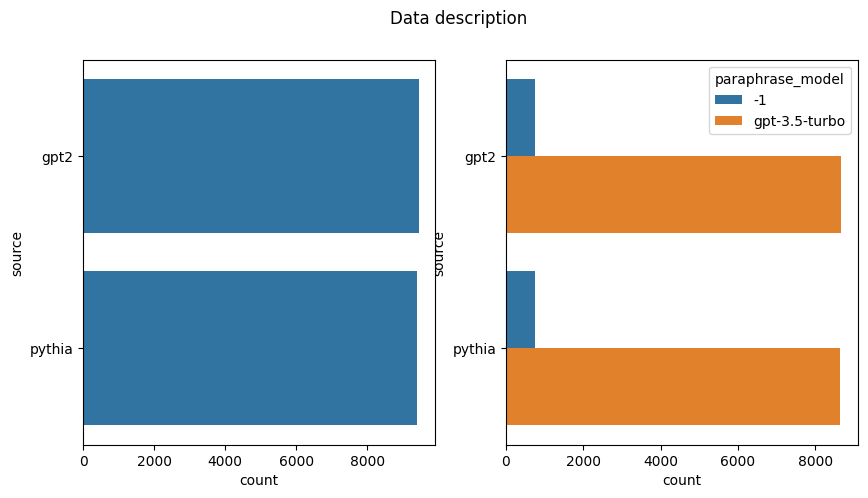

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plt.suptitle(f"Data description")
sns.countplot(data, y="source", ax=axes[0])
sns.countplot(data, y="source", hue = "paraphrase_model", ax=axes[1])

plt.show()

### Analysis of repetitivness metrics without paraphrasing

In [16]:
no_para_data = data[(data['clean_paraphase_type'] ==0) | (data['source'] == "roc_story")]
no_para_data['source'].value_counts()


source
pythia    5097
gpt2      5087
Name: count, dtype: int64

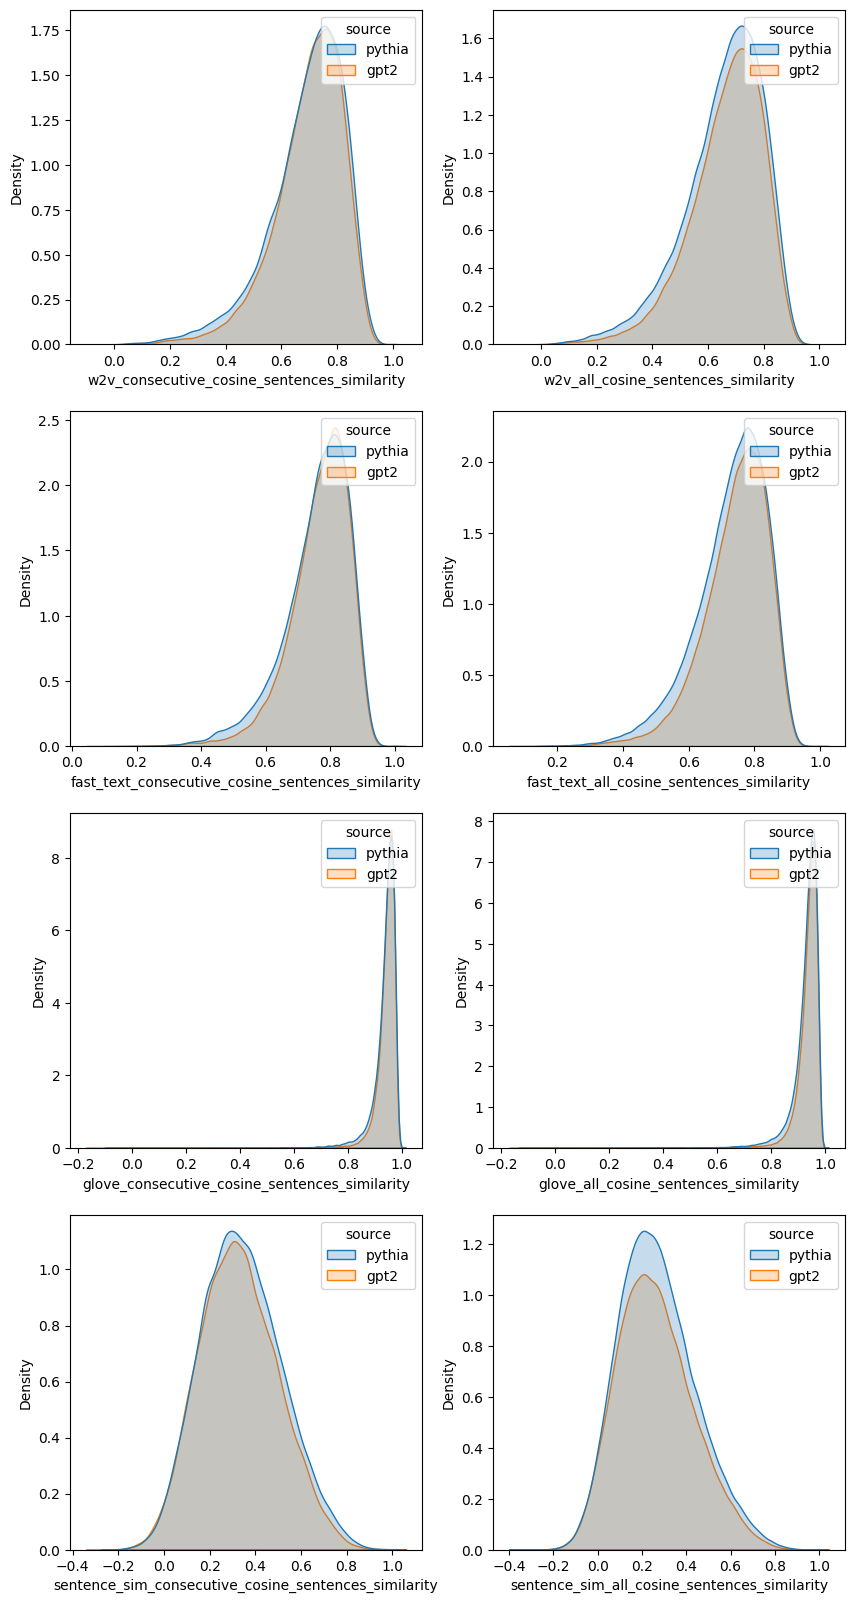

In [17]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))
for i,model_name in enumerate(['w2v',"fast_text","glove","sentence_sim"]):
    for j,sim_type in enumerate(['consecutive_cosine_sentences_similarity', 'all_cosine_sentences_similarity']):
        df_compare = pd.DataFrame()
        source_list = []
        sim_list = []
        for source in ["pythia", "gpt2"]:
            sim = flatten_list(no_para_data[no_para_data['source']==source][model_name + '_' + sim_type].tolist())
            source_list.extend([source]*len(sim))
            sim_list.extend(sim)
        df_compare[model_name + '_' + sim_type] = sim_list
        df_compare['source'] = source_list
        sns.kdeplot(x=model_name + '_' + sim_type, hue = "source", data=df_compare, fill=True, common_norm=True, ax=axes[i,j], )#kde=True)
        #axes[i,j].set_title(model_name + '_' + sim_type)
        
        #print(model_name + '_' + sim_type)
        #df_compare['target'] = df_compare['source'].apply(lambda x: 1 if x == 'roc_story' else 0)
        #print(compute_wilcoxon(df_compare, x="target", y=model_name + '_' + sim_type, alt="two-sided") )
plt.show()

In [18]:
semantic_features = data.filter(regex = "score").columns.tolist()
semantic_features

['narrative_speed_score',
 'reduction_score_PCA_explained_variance',
 'reduction_score_PCA_prop_of_components',
 'cluster_density_score_HDBSCAN',
 'cluster_reverse_silhouette_score_HDBSCAN',
 'cluster_density_score_MeanShift',
 'cluster_reverse_silhouette_score_MeanShift',
 'regression_coef_density_score_Lasso',
 'regression_error_score_Lasso',
 'reduction_score_Lasso']

In [19]:
no_para_data['regression_error_score_Lasso']

0        0.307121
1        0.223960
2        0.130507
3        0.078775
4        0.107191
           ...   
18843    0.535823
18844    0.470090
18845    0.264335
18846    0.375772
18847    0.715719
Name: regression_error_score_Lasso, Length: 10184, dtype: float64

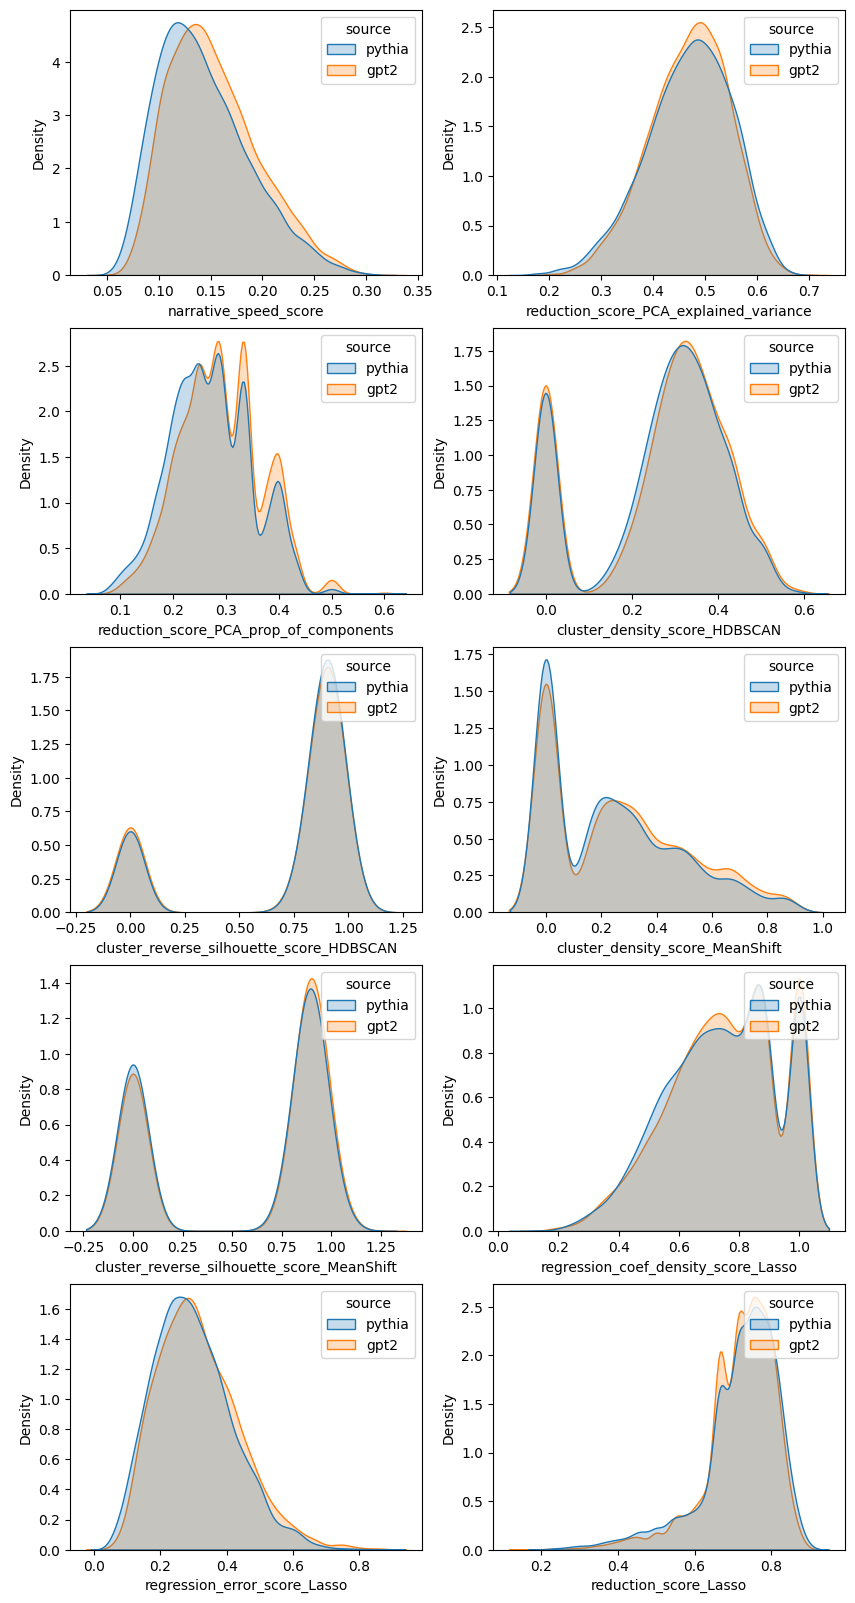

In [20]:
semantic_features = data.filter(regex = "score").columns.tolist()
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))
for i,feature in enumerate(semantic_features): 
    df_compare = pd.DataFrame()
    source_list = []
    sim_list = []
    for source in ["pythia", "gpt2"]:
        sim = flatten_list(no_para_data[no_para_data['source']==source][feature].tolist())
        source_list.extend([source]*len(sim))
        sim_list.extend(sim)
    df_compare[feature] = sim_list
    df_compare['source'] = source_list
    a = i//2
    b = i%2
    #print(a,b)
    sns.kdeplot(x=feature, hue = "source", data=df_compare, fill=True, common_norm=True, ax=axes[a,b], )#kde=True)
    

In [47]:
test = semantic_features + data.filter(regex='similarity').columns.tolist()
data['source_enc'] = data["source"].apply(lambda x : 1 if x =="gpt2" else 0)
results = sa.compute_wilc_table(data, ['source_enc'],sim_cols, seuil=0.05)
results

x                                                  y     stats  \
0   source_enc              w2v_all_wmd_sentences_similarity_mean -3.067659   
1   source_enc      w2v_consecutive_wmd_sentences_similarity_mean -3.806587   
2   source_enc  fast_text_consecutive_cosine_sentences_similar...  5.463600   
3   source_enc     fast_text_all_cosine_sentences_similarity_mean  5.359583   
4   source_enc        fast_text_all_wmd_sentences_similarity_mean -3.108684   
5   source_enc  fast_text_consecutive_wmd_sentences_similarity... -5.422040   
6   source_enc  glove_consecutive_cosine_sentences_similarity_...  6.737440   
7   source_enc         glove_all_cosine_sentences_similarity_mean  6.005642   
8   source_enc            glove_all_wmd_sentences_similarity_mean -7.996270   
9   source_enc    glove_consecutive_wmd_sentences_similarity_mean -8.158159   
10  source_enc  sentence_sim_consecutive_cosine_sentences_simi... -9.449418   
11  source_enc  sentence_sim_all_cosine_sentences_similarity_mean -8.545373   
12  source_enc  lemma_consecutive_jaccard_sentences_similarity... -5.819282   
13  source_enc        lemma_all_jaccard_sentences_similarity_mean -5.086362   

            pval     cohen     power  
0   2.157428e-03 -0.024203  0.180211  
1   1.408977e-04 -0.049560  0.795561  
2   4.665744e-08  0.118508  1.000000  
3   8.341415e-08  0.124354  1.000000  
4   1.879223e-03 -0.046874  0.739398  
5   5.892265e-08 -0.085897  0.999550  
6   1.612010e-11  0.109138  1.000000  
7   1.905762e-09  0.113250  1.000000  
8   1.282448e-15 -0.114491  1.000000  
9   3.401703e-16 -0.127404  1.000000  
10  3.407187e-21 -0.150651  1.000000  
11  1.281222e-17 -0.141055  1.000000  
12  5.910088e-09 -0.097584  0.999981  
13  3.649971e-07 -0.084144  0.999312

In [21]:
data['human_generated'] = data['source'].apply(lambda x: 1 if x == 'roc_story' else 0)
no_para_data = data[(data['clean_paraphase_type'] ==0) | (data['source'] == "roc_story")]

sim_cols = data.filter(regex='mean').columns.tolist()

target = ["human_generated"] #"first_paraphrase"]
results = sa.compute_wilc_table(no_para_data, target,sim_cols, seuil=0.05)
results.head(100)

Empty DataFrame
Columns: [x, y, stats, pval, cohen, power]
Index: []

In [22]:
data['human_generated'] = data['source'].apply(lambda x: 1 if x == 'roc_story' else 0)
utils_data = data[(data['clean_paraphase_type'] ==0) & (data['source'] != "roc_story")]

sim_cols = data.filter(regex='similarity').columns.tolist()

target = ["human_generated"] #"first_paraphrase"]
results = sa.compute_wilc_table(utils_data, target,sim_cols, seuil=0.05)
results.head(100)

Empty DataFrame
Columns: [x, y, stats, pval, cohen, power]
Index: []

###  Human vs Pythia  and GPT-2
Based on similarity metric, the human generated story are very different from the other two. This is a bit unexpected to found such difference in the non-paraphrased dataset.

## Pythia  vs GPT-2
We do not observe differences between pythia and gpt-2 stories.

In [23]:
data['paraphrase_model'].value_counts()

paraphrase_model
gpt-3.5-turbo    17326
-1                1522
Name: count, dtype: int64

In [50]:
data['has_paraphrase'].value_counts()

has_paraphrase
0    10184
1     8664
Name: count, dtype: int64

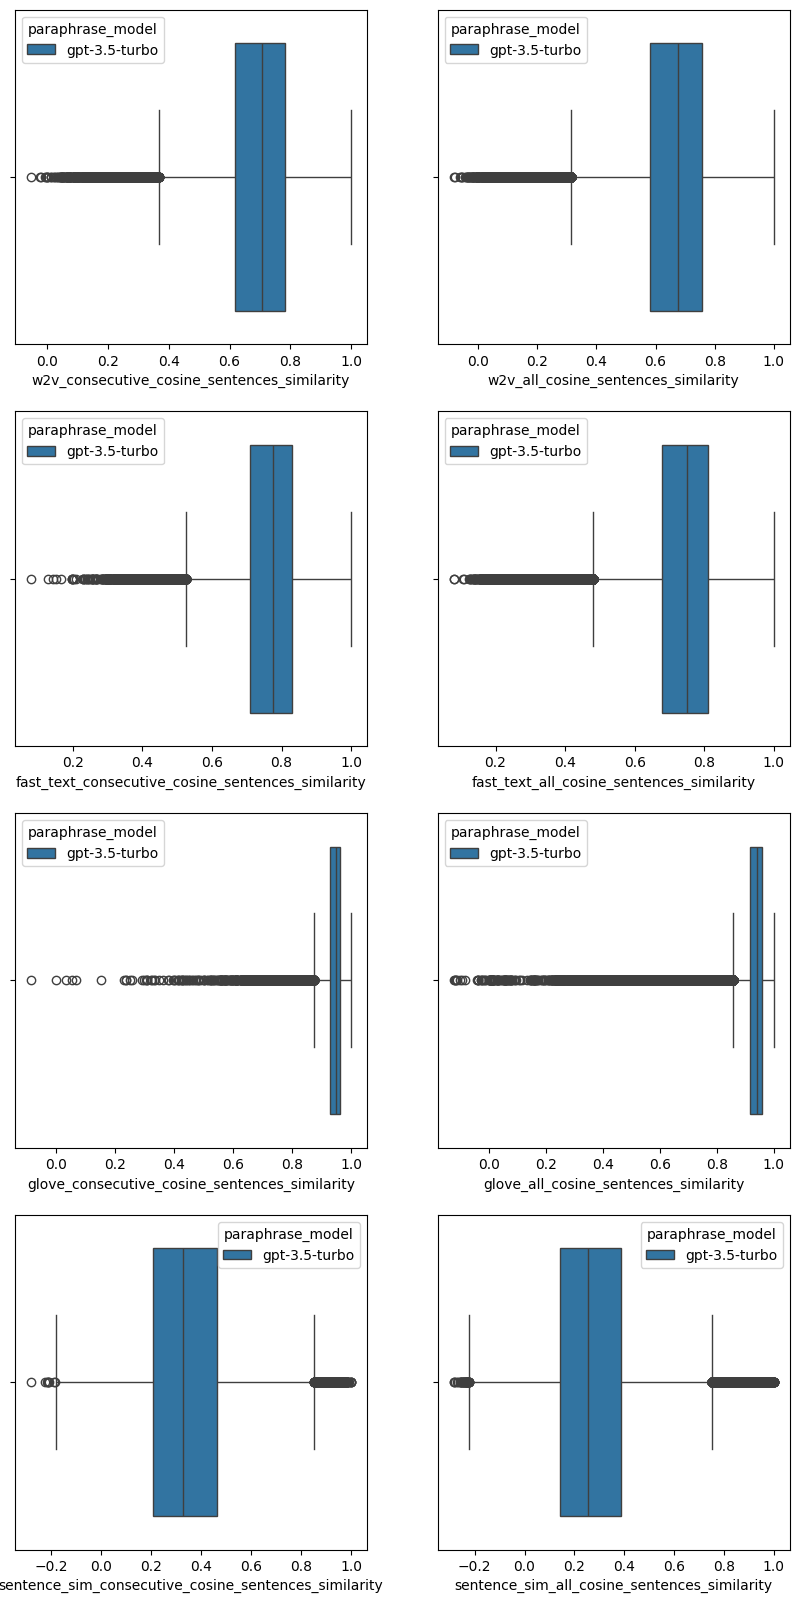

In [24]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))
para_data = data[(data['clean_paraphase_type'] !=0) & (data['source'] != "roc_story")]
for i,model_name in enumerate(['w2v',"fast_text","glove","sentence_sim"]):
    for j,sim_type in enumerate(['consecutive_cosine_sentences_similarity', 'all_cosine_sentences_similarity']):
        df_compare = pd.DataFrame()
        source_list = []
        sim_list = []
        for paraphrase_model in ["gpt-3.5-turbo", "ibm-qcpg-sentences"]:
            sim = flatten_list(para_data[para_data['paraphrase_model']==paraphrase_model][model_name + '_' + sim_type].tolist())
            source_list.extend([paraphrase_model]*len(sim))
            sim_list.extend(sim)
        df_compare[model_name + '_' + sim_type] = sim_list
        df_compare['paraphrase_model'] = source_list
        #sns.kdeplot(x=model_name + '_' + sim_type, hue = "paraphrase_model", data=df_compare, fill=True, common_norm=True, ax=axes[i,j], )#kde=True)
        sns.boxplot(x=model_name + '_' + sim_type, hue = "paraphrase_model", data=df_compare,  ax=axes[i,j], )#kde=True)

        #axes[i,j].set_title(model_name + '_' + sim_type)

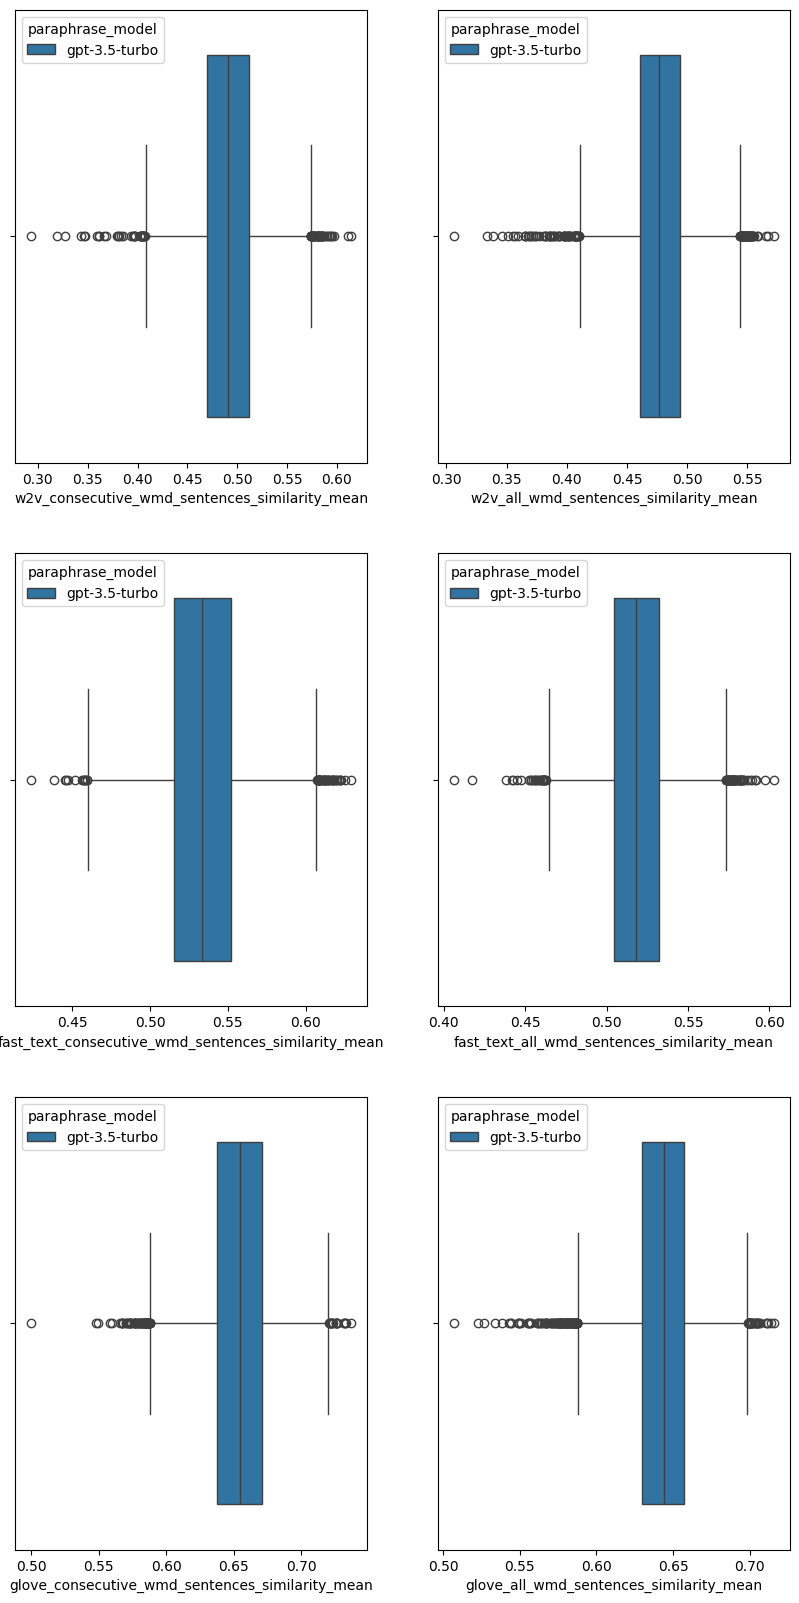

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 20))
para_data = data[data['clean_paraphase_type'] !=0]
for i,model_name in enumerate(['w2v',"fast_text","glove"]):
    for j,sim_type in enumerate(['consecutive_wmd_sentences_similarity_mean', 'all_wmd_sentences_similarity_mean']):
        
        sns.boxplot(x=model_name + '_' + sim_type, hue = "paraphrase_model", data=para_data,  ax=axes[i,j])#kde=True)

        #axes[i,j].set_title(model_name + '_' + sim_type)

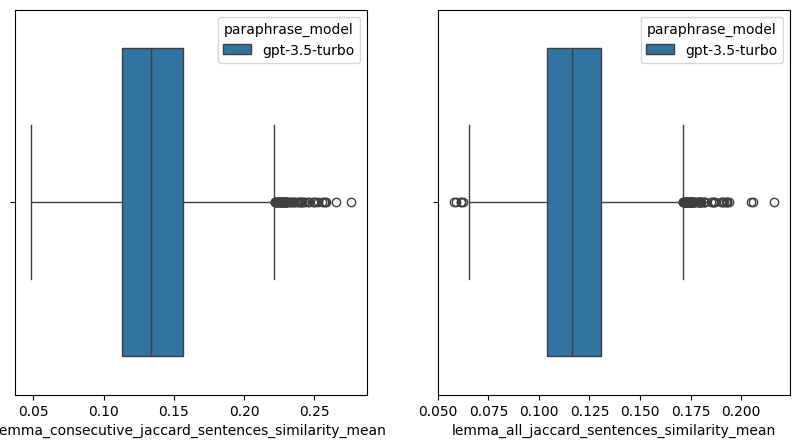

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
para_data = data[data['clean_paraphase_type'] !=0]
for i,model_name in enumerate(['lemma']):
    for j,sim_type in enumerate(['consecutive_jaccard_sentences_similarity_mean', 'all_jaccard_sentences_similarity_mean']):
        sns.boxplot(x=model_name + '_' + sim_type, hue = "paraphrase_model", data=para_data,  ax=axes[j])#kde=True)


In [27]:
sim_cols = data.filter(regex='mean').columns.tolist()
para_data['paraphrase_model_enc'] = para_data['paraphrase_model'].apply(lambda x: 1 if x == 'gpt-3.5-turbo' else 0)
target = ["paraphrase_model_enc"] #"first_paraphrase"]
results = sa.compute_wilc_table(para_data, target,sim_cols, seuil=0.05)
results.head(100)

Empty DataFrame
Columns: [x, y, stats, pval, cohen, power]
Index: []

### GPT3.5 vs IMB QCGP paraphraser

Based on our similarity metric, we observe that the paraphraser are statistically different, particularly according to the word movers distance and the sentence similarity model with cosine. However we observe small effect sizes.

## Paraphrase analysis

Where ? How many ? etc.

**When:** at which step of the story generation process ?

**Where:** at which position in the story, which sentence ?

**How many:** how many paraphrases are generated ?

**How:** Which model ? Which distance to the original sentence ? 


In [4]:
with_paraphrase = para_data[para_data['clean_paraphase_type']!=0]
# not_roc_data['has_paraphrase'] = not_roc_data['clean_paraphase_type'].apply(lambda x: 1 if x != 0 else 0)

NameError: name 'para_data' is not defined

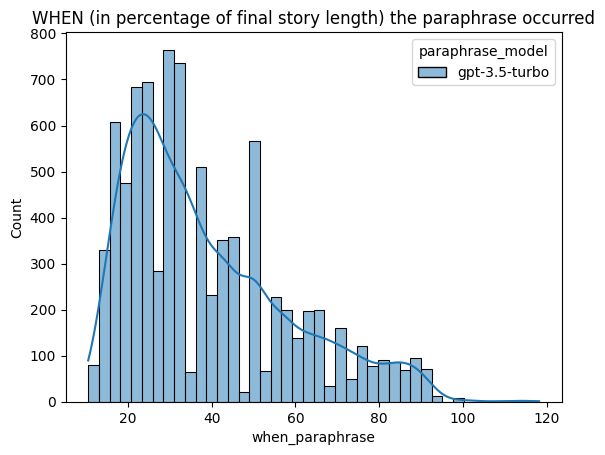

In [29]:
with_paraphrase['when_paraphrase'] = with_paraphrase.apply(lambda x: x.clean_paraphrase_index[1]/x.num_sentences*100, axis=1)
sns.histplot(data = with_paraphrase, x = 'when_paraphrase', hue  = "paraphrase_model", kde = True) 
plt.title("WHEN (in percentage of final story length) the paraphrase occurred")
plt.show()

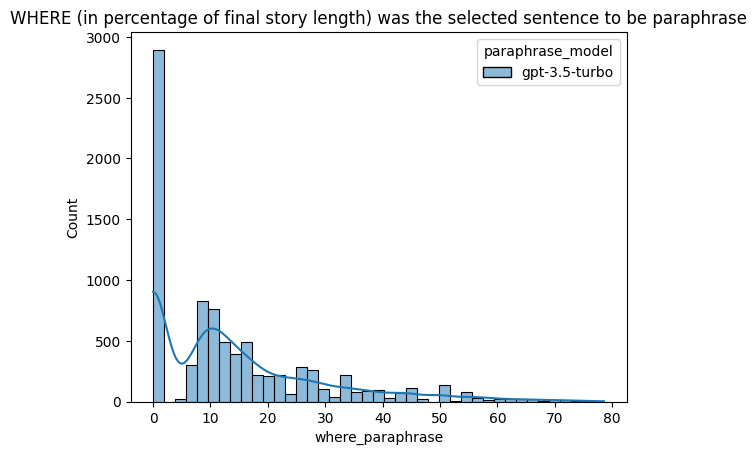

In [30]:
with_paraphrase['where_paraphrase'] = with_paraphrase.apply(
    lambda x: x.clean_paraphrase_index[0]/x.num_sentences*100, axis=1)
sns.histplot(data = with_paraphrase, x = 'where_paraphrase', hue  = "paraphrase_model", kde = True) 
plt.title("WHERE (in percentage of final story length) was the selected sentence to be paraphrase")
plt.show()

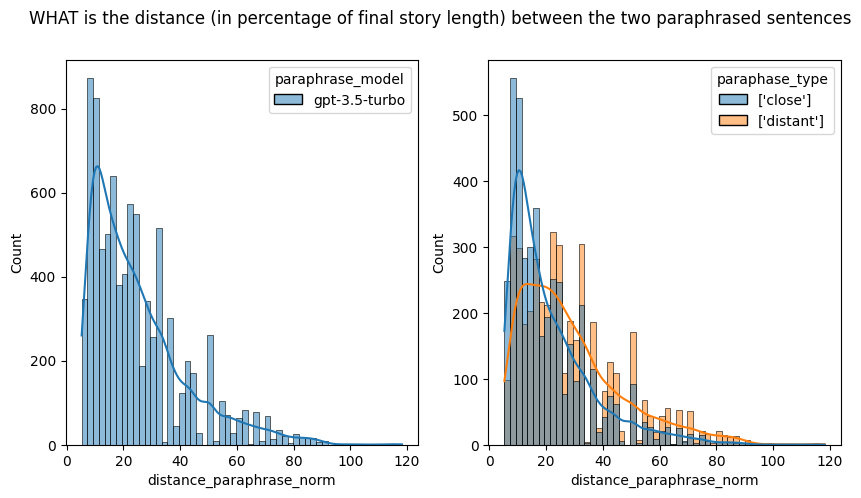

In [31]:
with_paraphrase['distance_paraphrase_norm'] = with_paraphrase.apply(
    lambda x: (x.clean_paraphrase_index[1]-x.clean_paraphrase_index[0])/x.num_sentences*100, axis=1)

hue_a = "paraphrase_model"
hue_b = "paraphase_type"
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
sns.histplot(data = with_paraphrase, x = 'distance_paraphrase_norm', hue  = hue_a, kde = True, ax=axes[0]) 
sns.histplot(data = with_paraphrase, x = 'distance_paraphrase_norm', hue  = hue_b,kde = True, ax=axes[1])
plt.suptitle("WHAT is the distance (in percentage of final story length) between the two paraphrased sentences")
plt.show()



<Axes: >

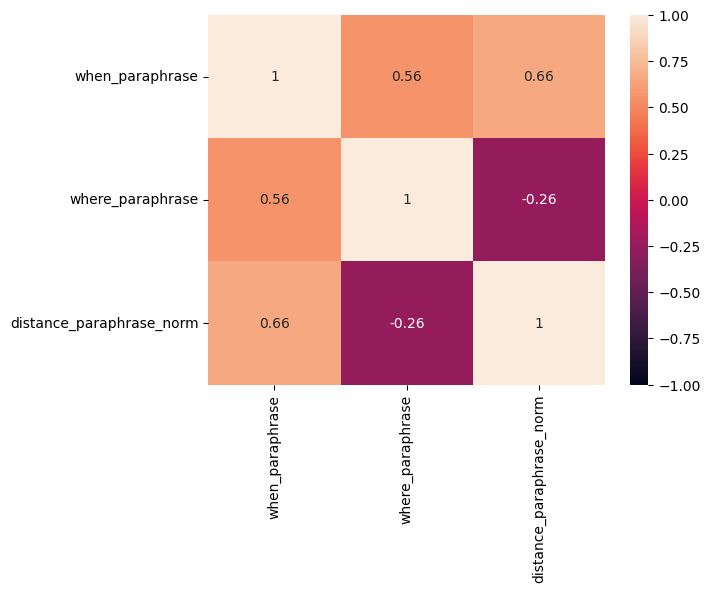

In [32]:
sns.heatmap(with_paraphrase[["when_paraphrase", "where_paraphrase", "distance_paraphrase_norm"]].corr(),vmin=-1, vmax=1, annot=True)

## How similarity metrics can detect paraphrasing ?

The first idea is to check if the similarity metrics are different between two paraphrases vs other sentences.

Then, we want to check ho the metric can identify paraphrasing, semantic repetition. We will compared generated vs generated with online paraphrased. 

First; we will take all the stories.
Then, we will select the story: 
- when the paraphrasing happened at the beginning of the story (<40%).
- where the sentence paraphrased is in the first part of the story (<50%)

We create the following categories:
- *consecutive paraphrasing:* the paraphrased sentence and the target sentence are consecutive.
- *distanced paraphrasing:* the paraphrased sentence and the target sentence are separated from at least 25% of the total length of the.

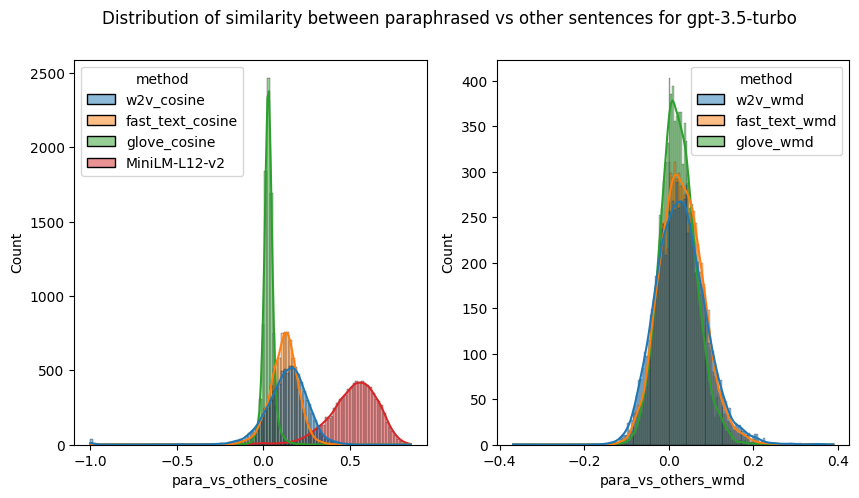

In [33]:
def plot_para_vs_others(with_paraphrase, para_model):
    diff_cosine = pd.DataFrame()
    diff_wmd = pd.DataFrame()
    model_cosine = []
    model_wmd = []
    para_vs_others_cosine= []
    para_vs_others_wmd = []

    for model_name in ['w2v',"fast_text","glove","sentence_sim"]:
        d = with_paraphrase[with_paraphrase['paraphrase_model']==para_model]

        if model_name == 'sentence_sim':
            
            para_vs_others_cosine.append(d[model_name + '_para_vs_others_cosine_sentences_similarity'].tolist())
            name = "MiniLM-L12-v2"
            model_cosine.append([name]*len(d))
        
               
        else :
            for sim_method in ['cosine','wmd']:
                if sim_method == "cosine":
                    para_vs_others_cosine.append(d[model_name + '_para_vs_others_' + sim_method + '_sentences_similarity'].tolist())
                    name = model_name + '_' + sim_method
            
                    model_cosine.append([name]*len(d))
                else :
                    para_vs_others_wmd.append(d[model_name + '_para_vs_others_' + sim_method + '_sentences_similarity'].tolist())
                    name = model_name + '_' + sim_method
            
                    model_wmd.append([name]*len(d))

    diff_cosine['para_vs_others_cosine'] = flatten_list(para_vs_others_cosine)
    diff_cosine['method'] = flatten_list(model_cosine)


    diff_wmd['para_vs_others_wmd'] = flatten_list(para_vs_others_wmd)
    diff_wmd['method'] = flatten_list(model_wmd)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    plt.suptitle(f"Distribution of similarity between paraphrased vs other sentences for {para_model}")
    sns.histplot( x="para_vs_others_cosine", hue = "method", data=diff_cosine,kde=True, fill=True, ax=axes[0])
    sns.histplot( x="para_vs_others_wmd", hue = "method", data=diff_wmd,kde=True, fill=True, ax=axes[1])
    plt.show()

for para_model in ['gpt-3.5-turbo']:
    plot_para_vs_others(with_paraphrase, para_model)

In [ ]:
def plot_para_vs_others(with_paraphrase, para_model):
    diff_cosine = pd.DataFrame()
    diff_wmd = pd.DataFrame()
    model_cosine = []
    model_wmd = []
    para_vs_others_cosine= []
    para_vs_others_wmd = []

    for model_name in ['w2v',"fast_text","glove","sentence_sim"]:
        d = with_paraphrase[with_paraphrase['paraphrase_model']==para_model]

        if model_name == 'sentence_sim':
            
            para_vs_others_cosine.append(d[model_name + '_para_vs_others_cosine_sentences_similarity'].tolist())
            name = "MiniLM-L12-v2"
            model_cosine.append([name]*len(d))
        
               
        else :
            for sim_method in ['cosine','wmd']:
                if sim_method == "cosine":
                    para_vs_others_cosine.append(d[model_name + '_para_vs_others_' + sim_method + '_sentences_similarity'].tolist())
                    name = model_name + '_' + sim_method
            
                    model_cosine.append([name]*len(d))
                else :
                    para_vs_others_wmd.append(d[model_name + '_para_vs_others_' + sim_method + '_sentences_similarity'].tolist())
                    name = model_name + '_' + sim_method
            
                    model_wmd.append([name]*len(d))

    diff_cosine['para_vs_others_cosine'] = flatten_list(para_vs_others_cosine)
    diff_cosine['method'] = flatten_list(model_cosine)


    diff_wmd['para_vs_others_wmd'] = flatten_list(para_vs_others_wmd)
    diff_wmd['method'] = flatten_list(model_wmd)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    plt.suptitle(f"Distribution of similarity between paraphrased vs other sentences for {para_model}")
    sns.histplot( x="para_vs_others_cosine", hue = "method", data=diff_cosine,kde=True, fill=True, ax=axes[0])
    sns.histplot( x="para_vs_others_wmd", hue = "method", data=diff_wmd,kde=True, fill=True, ax=axes[1])
    plt.show()

for para_model in ['gpt-3.5-turbo']:
    plot_para_vs_others(with_paraphrase, para_model)

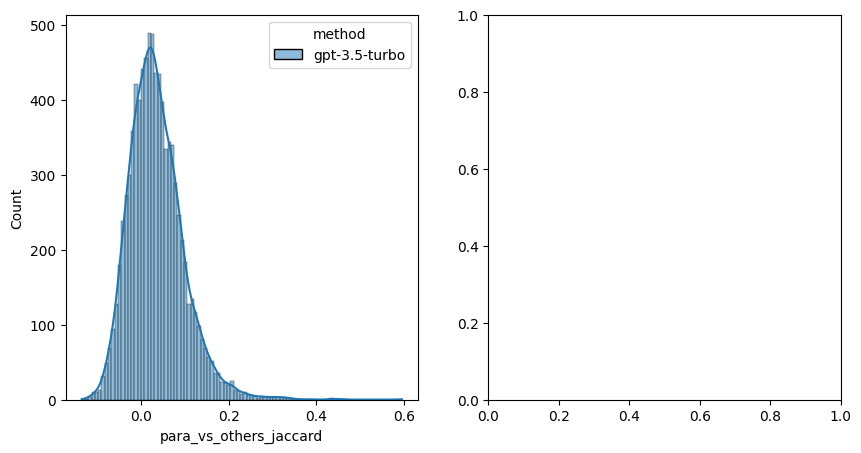

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
for i,model in enumerate(['gpt-3.5-turbo']): #'ibm-qcpg-sentences'
    df = pd.DataFrame()
    para_vs_others_jaccard = []
    model_jaccard = [] 
    d = with_paraphrase[with_paraphrase['paraphrase_model']==para_model]
    para_vs_others_jaccard.append(d["lemma" + '_para_vs_others_jaccard_sentences_similarity'].tolist())
    model_jaccard.append([model]*len(d))
    df['para_vs_others_jaccard'] = flatten_list(para_vs_others_jaccard)
    df['method'] = flatten_list(model_jaccard)
    sns.histplot( x="para_vs_others_jaccard", hue = "method", data=df,kde=True, fill=True, ax=axes[i])
plt.show()

Sentence embeddings models seems to be the most sensitive to paraphrasing. Glove is the less sensitive.

In [35]:
# which are the fatures best related to identify paraphrasing
not_roc_data = data[data['source'] != "roc_story"]

not_roc_data['has_paraphrase'] = not_roc_data['clean_paraphase_type'].apply(lambda x: 1 if x != 0 else 0)
not_roc_data['when_paraphrase'] = not_roc_data.apply(lambda x: x.clean_paraphrase_index[1]/x.num_sentences*100 if x.clean_paraphrase_index else -1 , axis=1)
not_roc_data['where_paraphrase'] = not_roc_data.apply(
    lambda x: x.clean_paraphrase_index[0]/x.num_sentences*100 if x.clean_paraphrase_index else -1, axis=1)

not_roc_data['distance_paraphrase_norm'] = not_roc_data.apply(
    lambda x: (x.clean_paraphrase_index[1]-x.clean_paraphrase_index[0])/x.num_sentences*100 if x.clean_paraphrase_index else 0, axis=1)


not_roc_data_filter = not_roc_data[(not_roc_data.when_paraphrase <40) & (not_roc_data.where_paraphrase <50)]

print(f"Total data: {len(not_roc_data)}")
print(f"Total data filtered: {len(not_roc_data_filter)}")


Total data: 18848
Total data filtered: 11822


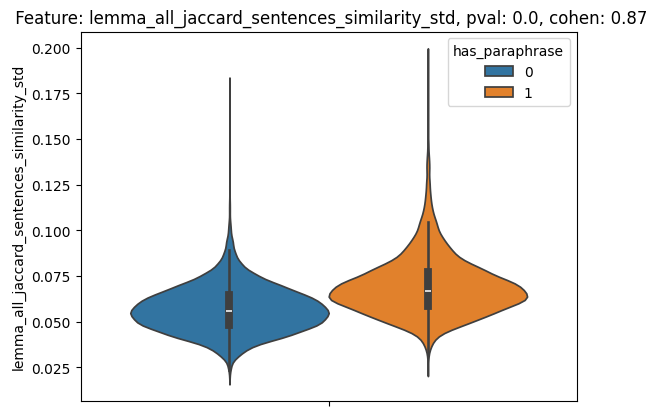

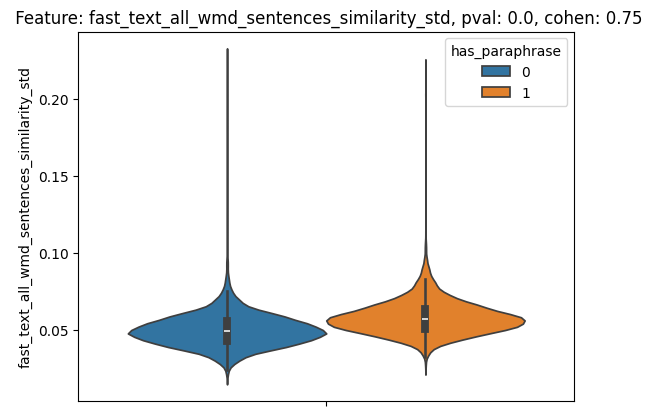

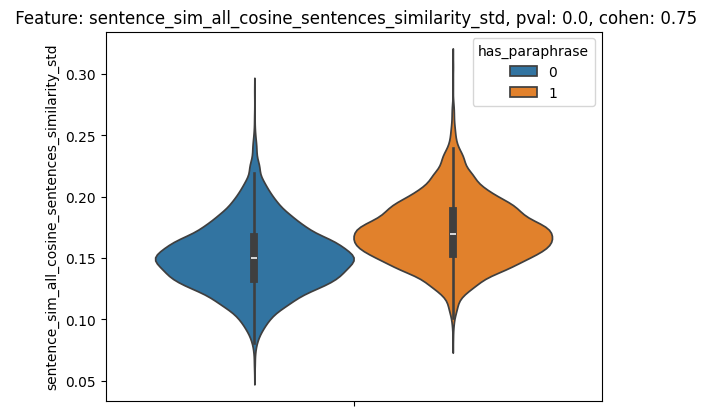

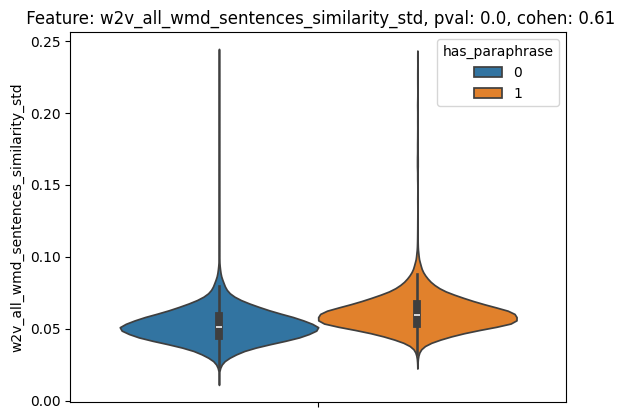

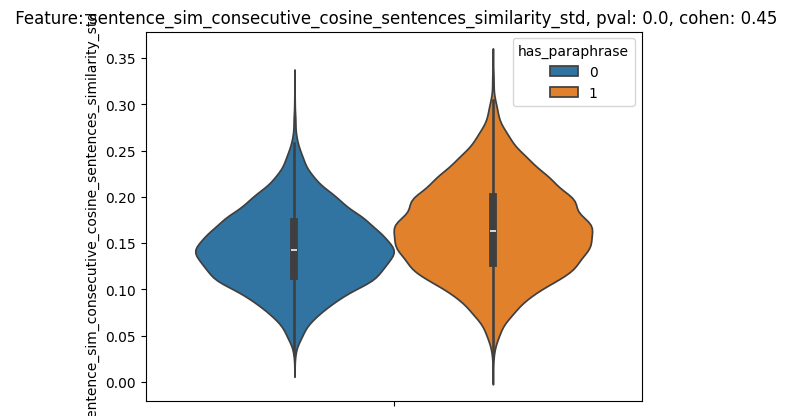

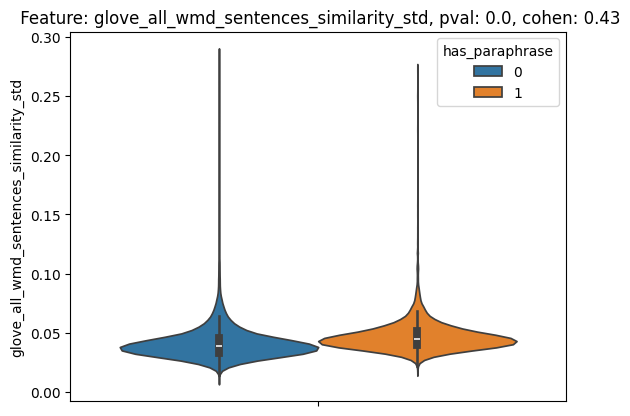

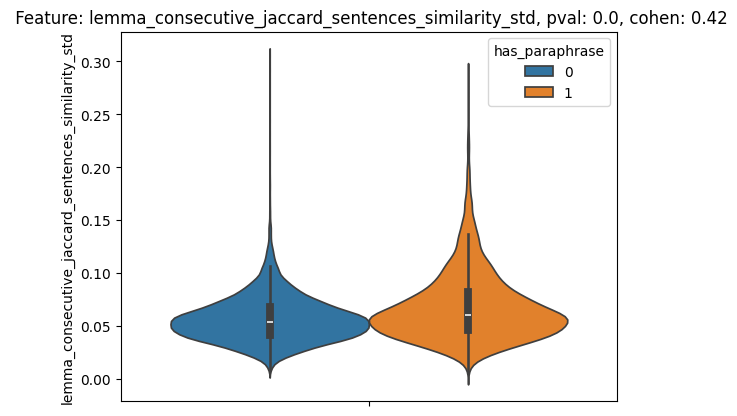

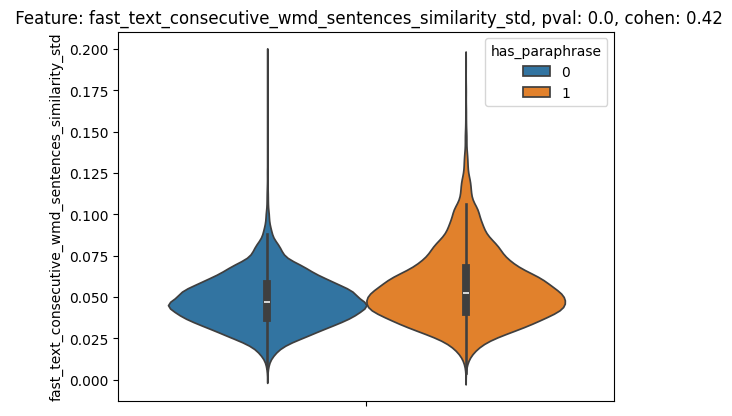

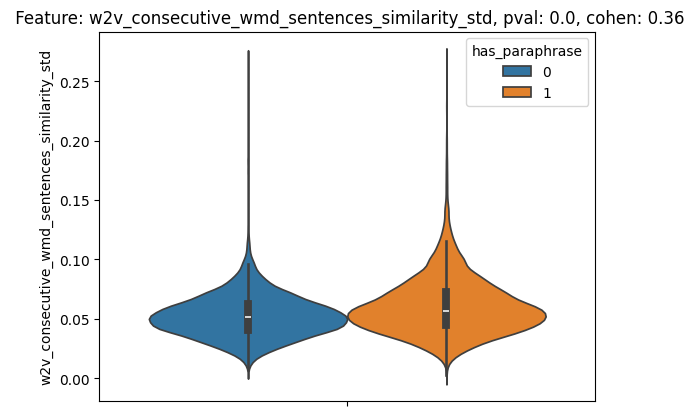

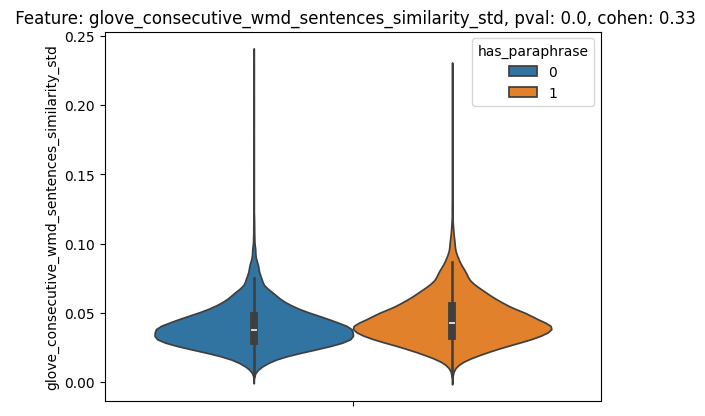

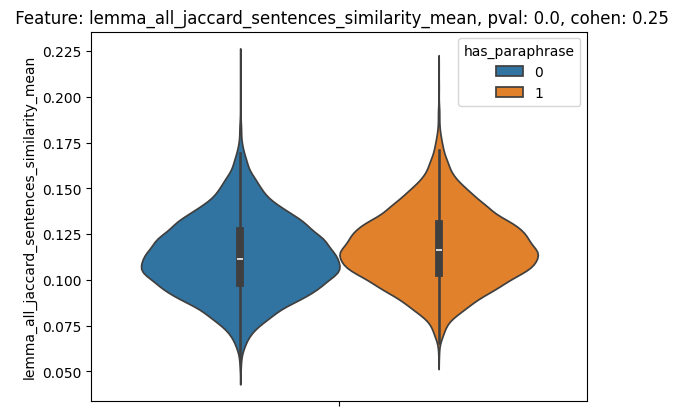

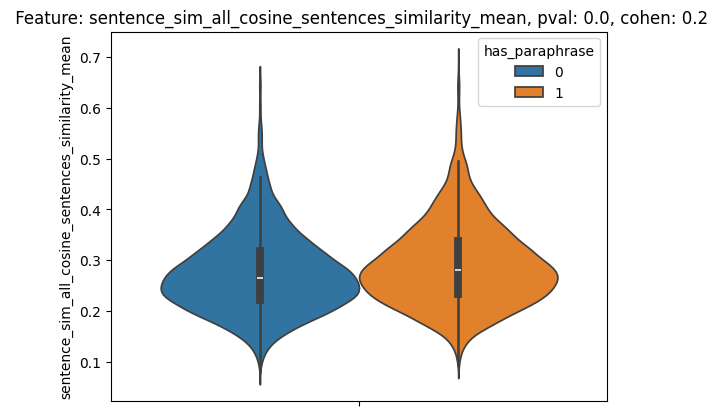

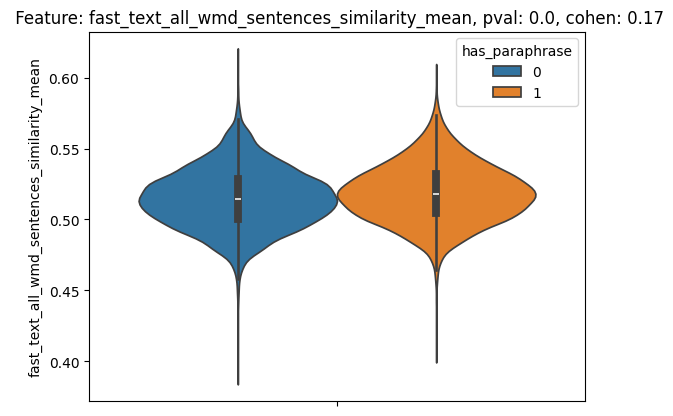

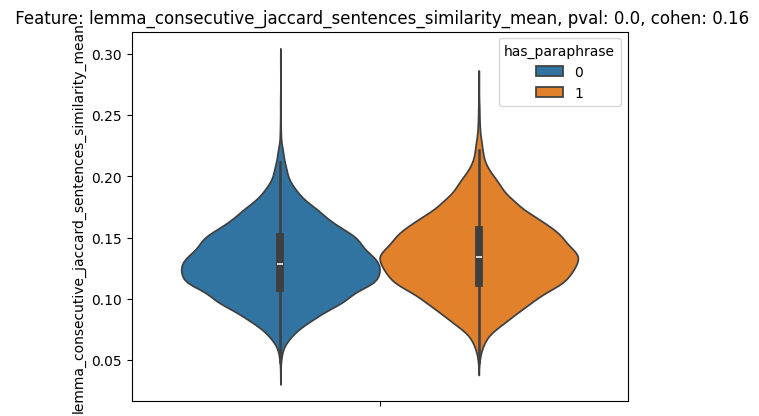

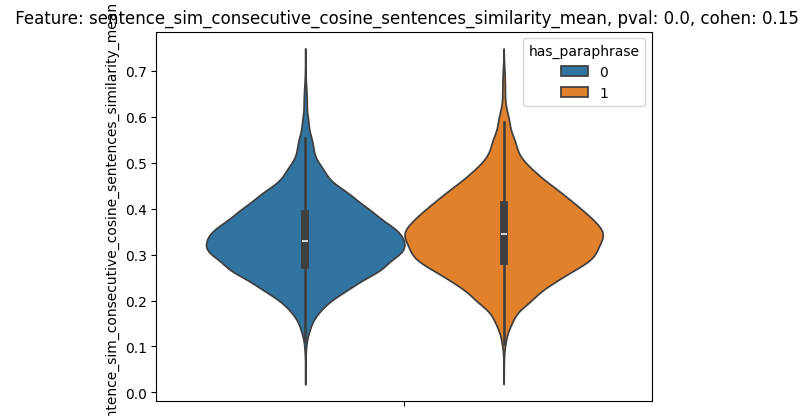

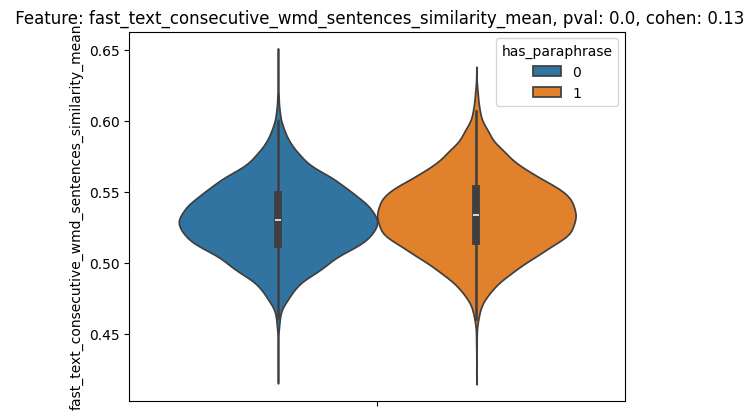

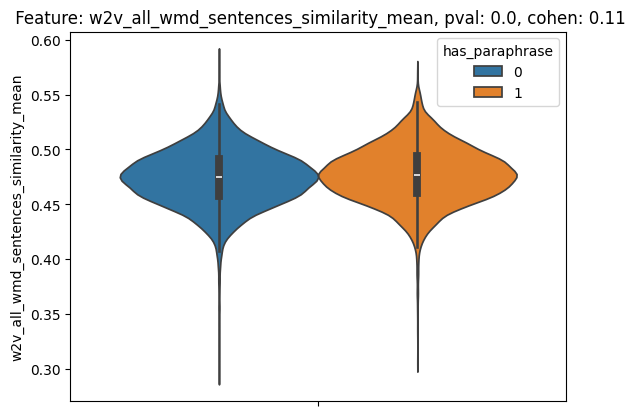

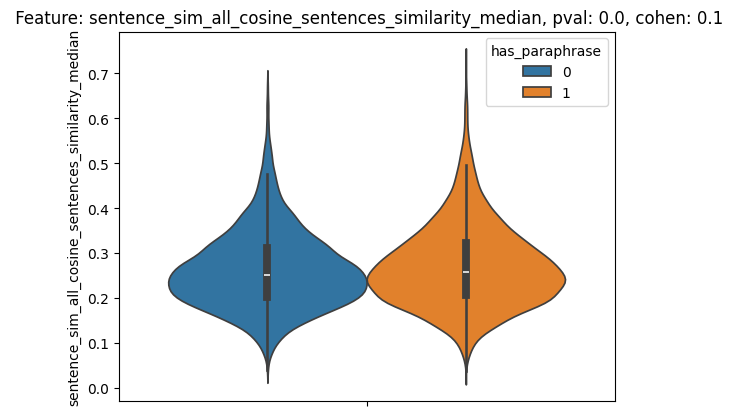

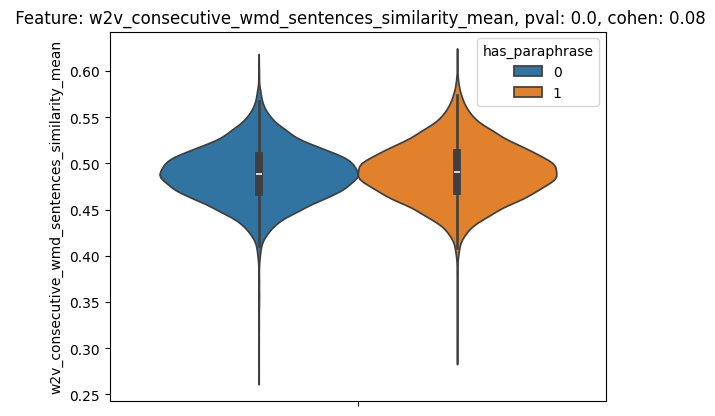

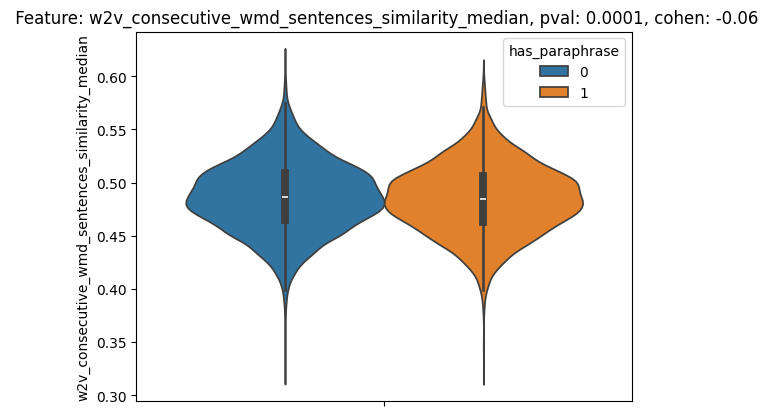

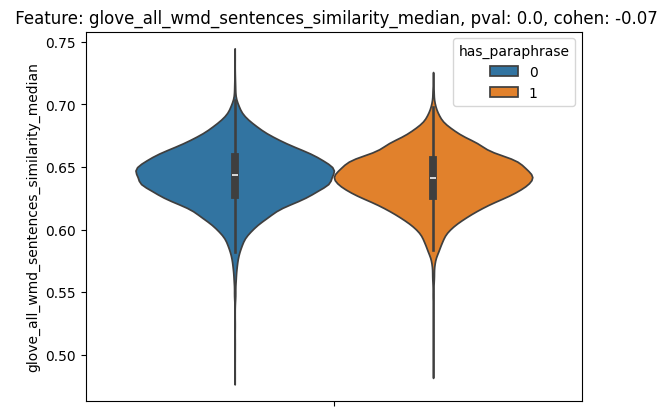

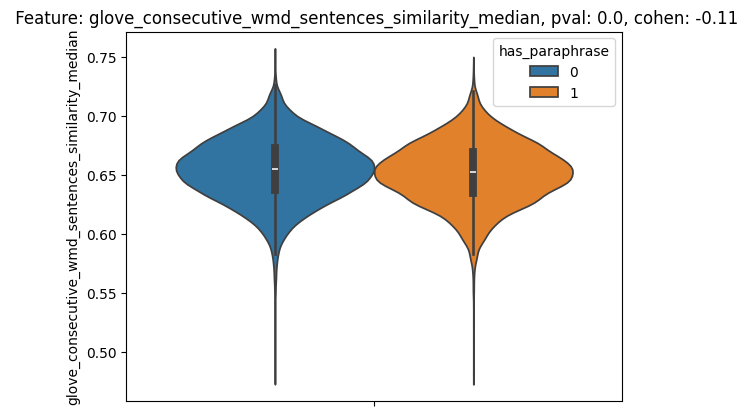

x                                                  y  \
32  has_paraphrase         lemma_all_jaccard_sentences_similarity_std   
14  has_paraphrase         fast_text_all_wmd_sentences_similarity_std   
28  has_paraphrase   sentence_sim_all_cosine_sentences_similarity_std   
6   has_paraphrase               w2v_all_wmd_sentences_similarity_std   
25  has_paraphrase  sentence_sim_consecutive_cosine_sentences_simi...   
21  has_paraphrase             glove_all_wmd_sentences_similarity_std   
30  has_paraphrase  lemma_consecutive_jaccard_sentences_similarity...   
16  has_paraphrase  fast_text_consecutive_wmd_sentences_similarity...   
9   has_paraphrase       w2v_consecutive_wmd_sentences_similarity_std   
23  has_paraphrase     glove_consecutive_wmd_sentences_similarity_std   
31  has_paraphrase        lemma_all_jaccard_sentences_similarity_mean   
26  has_paraphrase  sentence_sim_all_cosine_sentences_similarity_mean   
13  has_paraphrase        fast_text_all_wmd_sentences_similarity_mean   
29  has_paraphrase  lemma_consecutive_jaccard_sentences_similarity...   
24  has_paraphrase  sentence_sim_consecutive_cosine_sentences_simi...   
15  has_paraphrase  fast_text_consecutive_wmd_sentences_similarity...   
5   has_paraphrase              w2v_all_wmd_sentences_similarity_mean   
27  has_paraphrase  sentence_sim_all_cosine_sentences_similarity_m...   
7   has_paraphrase      w2v_consecutive_wmd_sentences_similarity_mean   
8   has_paraphrase    w2v_consecutive_wmd_sentences_similarity_median   
20  has_paraphrase          glove_all_wmd_sentences_similarity_median   
22  has_paraphrase  glove_consecutive_wmd_sentences_similarity_median   

             pval     cohen     power  
32   0.000000e+00  0.873728  1.000000  
14   0.000000e+00  0.754243  1.000000  
28   0.000000e+00  0.751469  1.000000  
6    0.000000e+00  0.611262  1.000000  
25  1.249929e-182  0.453007  1.000000  
21   0.000000e+00  0.434403  1.000000  
30  3.810148e-117  0.424117  1.000000  
16  2.202694e-124  0.420706  1.000000  
9   8.216001e-112  0.356406  1.000000  
23  8.712134e-114  0.329040  1.000000  
31   9.521007e-61  0.245909  1.000000  
26   1.476994e-43  0.201997  1.000000  
13   2.392542e-30  0.173963  1.000000  
29   1.468329e-27  0.164781  1.000000  
24   1.140446e-24  0.149733  1.000000  
15   3.966251e-17  0.128158  1.000000  
5    3.402935e-12  0.105486  0.999998  
27   5.481132e-10  0.096290  0.999970  
7    2.202912e-06  0.076723  0.996243  
8    5.212065e-05 -0.060292  0.939313  
20   2.402036e-08 -0.074693  0.994366  
22   3.856767e-13 -0.105020  0.999998

In [36]:
sim_features = not_roc_data.filter(regex='mean|std|med|mmin').columns.tolist()
stats = sa.compute_wilc_table(not_roc_data, ["has_paraphrase"],sim_features, seuil=0.01)
stats = stats.sort_values(by="cohen", ascending=False)
select = stats[stats.power>0.8][['x','y',"pval",'cohen','power']]
for features in select['y'].tolist():
    sns.violinplot(data=not_roc_data, hue="has_paraphrase", y=features)
    plt.title(f" Feature: {features}, pval: {select[select.y==features]['pval'].values[0].round(4)}, cohen: {select[select.y==features]['cohen'].values[0].round(2)}")
    plt.show()
select.head(len(select))

# do the same by removing the sentences that are paraphrased

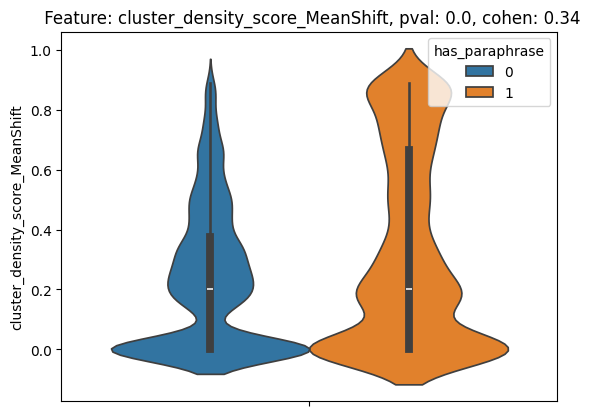

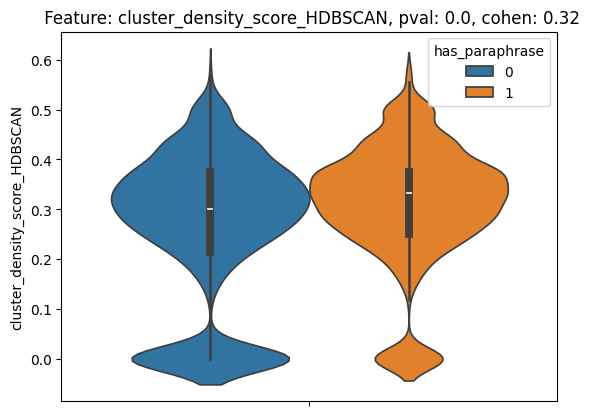

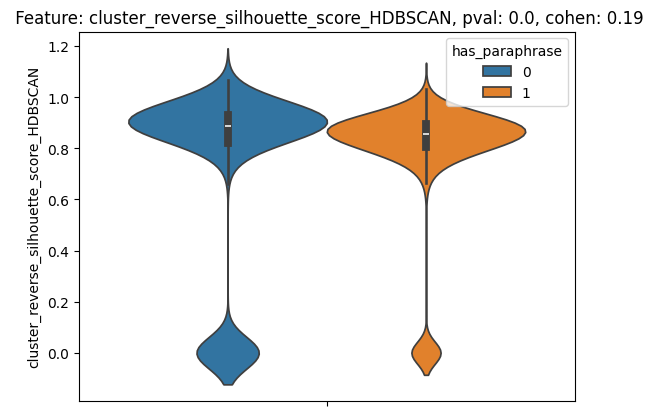

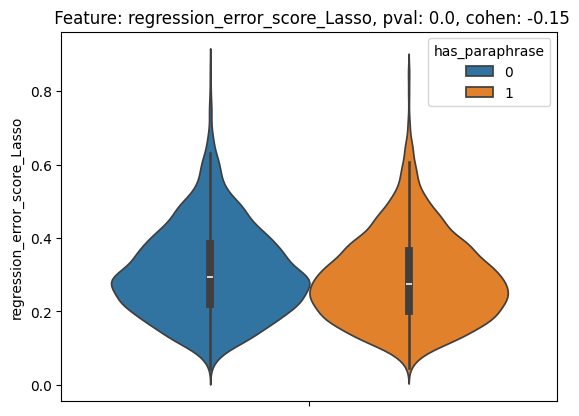

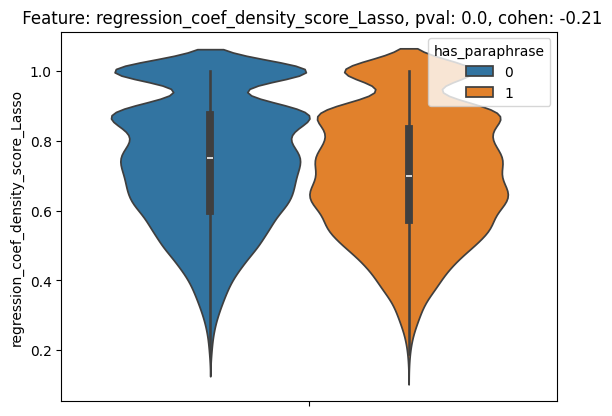

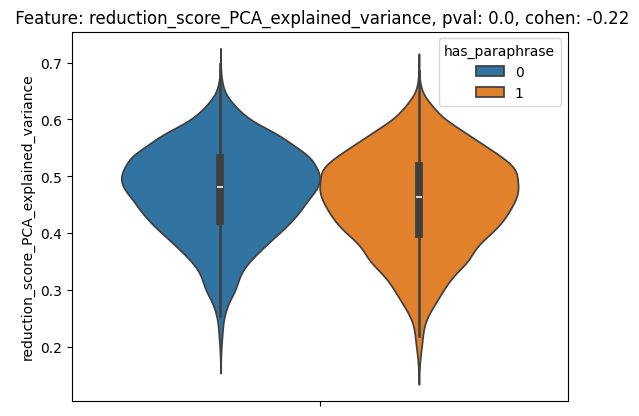

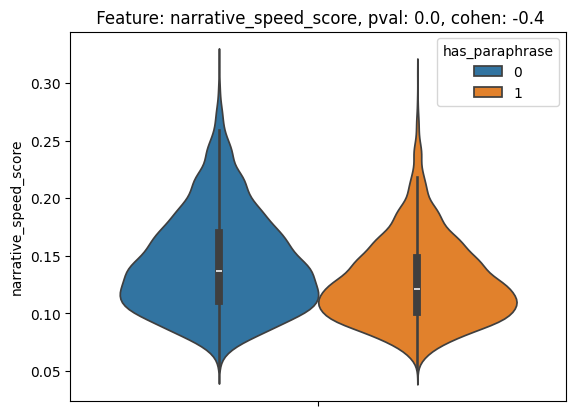

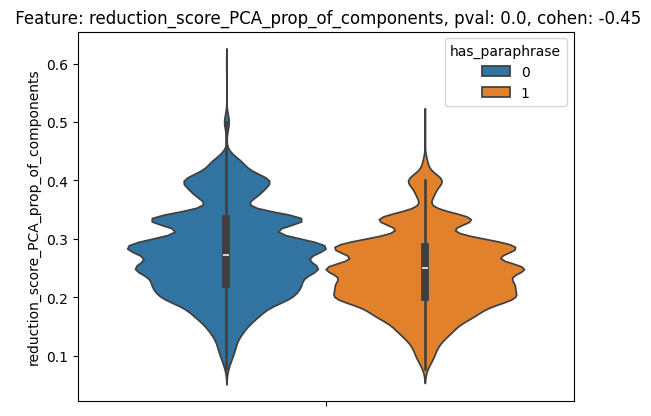

x                                         y           pval  \
5  has_paraphrase           cluster_density_score_MeanShift   1.238006e-33   
3  has_paraphrase             cluster_density_score_HDBSCAN   1.113449e-44   
4  has_paraphrase  cluster_reverse_silhouette_score_HDBSCAN   5.754860e-75   
8  has_paraphrase              regression_error_score_Lasso   8.909126e-17   
7  has_paraphrase       regression_coef_density_score_Lasso   1.068133e-28   
1  has_paraphrase    reduction_score_PCA_explained_variance   6.064005e-28   
0  has_paraphrase                     narrative_speed_score   2.738690e-91   
2  has_paraphrase    reduction_score_PCA_prop_of_components  7.373563e-117   

      cohen  power  
5  0.335988    1.0  
3  0.320104    1.0  
4  0.194884    1.0  
8 -0.151300    1.0  
7 -0.207044    1.0  
1 -0.216702    1.0  
0 -0.397893    1.0  
2 -0.449672    1.0

In [37]:
semantic_features = not_roc_data.filter(regex='score').columns.tolist()
stats = sa.compute_wilc_table(not_roc_data_filter, ["has_paraphrase"],semantic_features, seuil=0.01)
stats = stats.sort_values(by="cohen", ascending=False)
select = stats[stats.power>0.8][['x','y',"pval",'cohen','power']]

for features in select['y'].tolist():
    sns.violinplot(data=not_roc_data_filter, hue="has_paraphrase", y=features)
    plt.title(f" Feature: {features}, pval: {select[select.y==features]['pval'].values[0].round(4)}, cohen: {select[select.y==features]['cohen'].values[0].round(2)}")
    plt.show()

select.head(len(select))

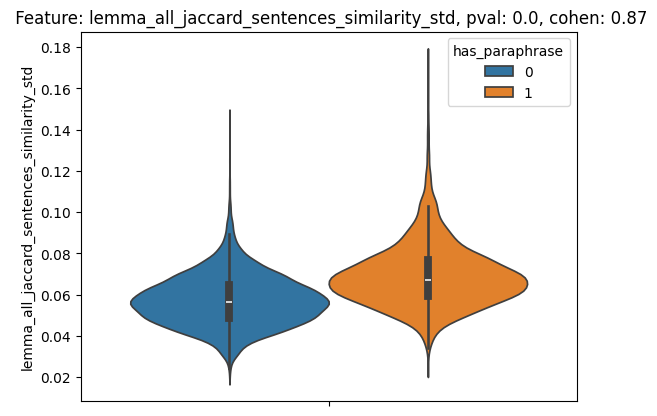

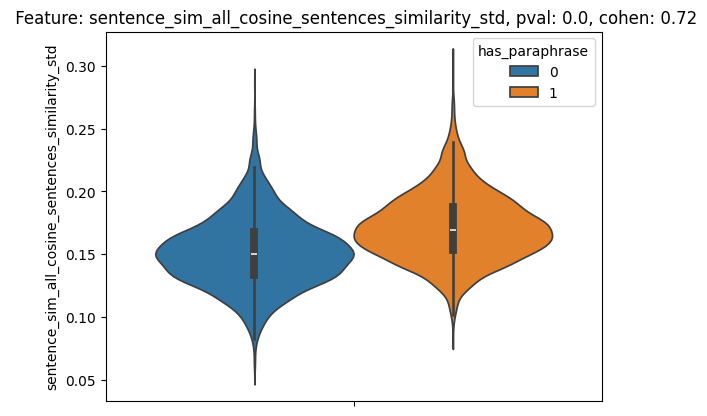

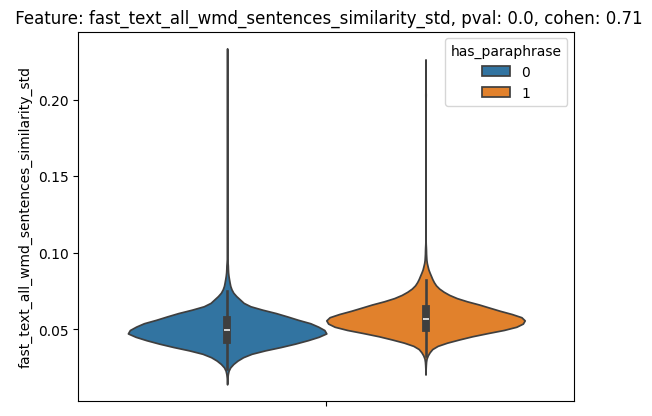

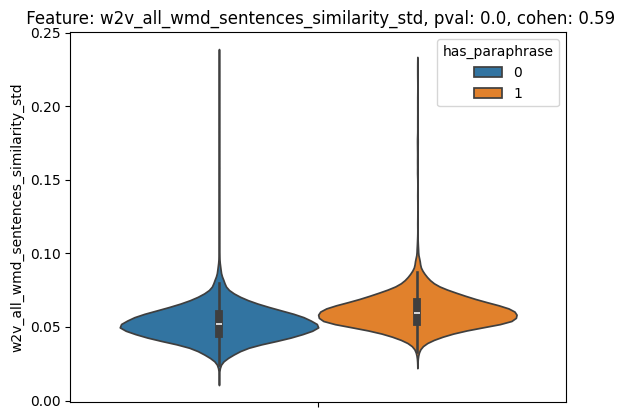

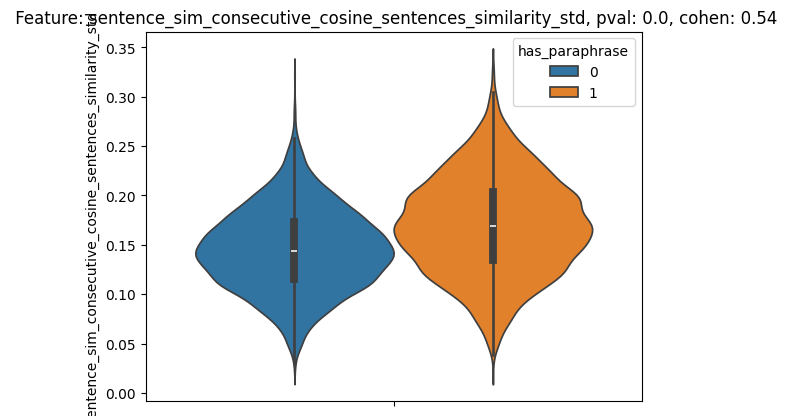

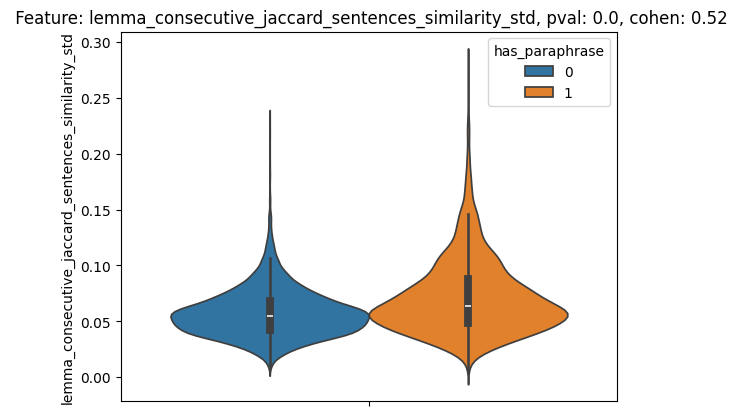

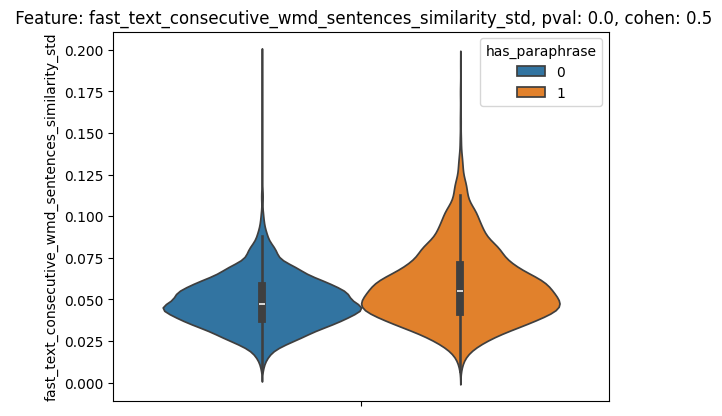

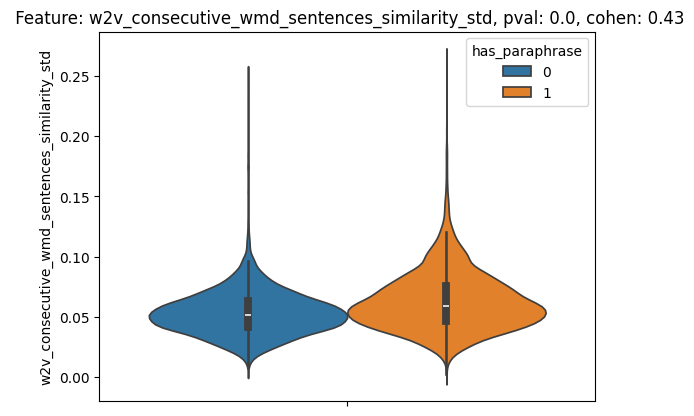

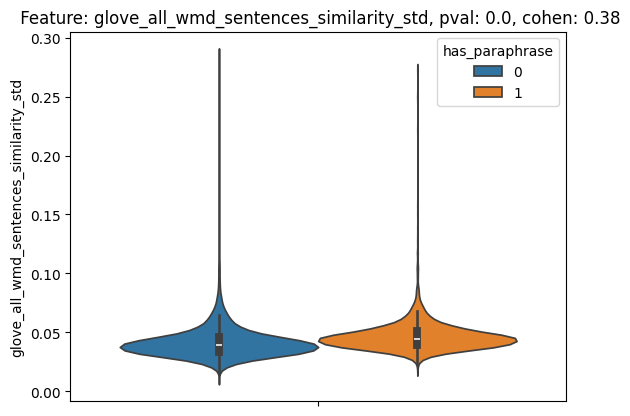

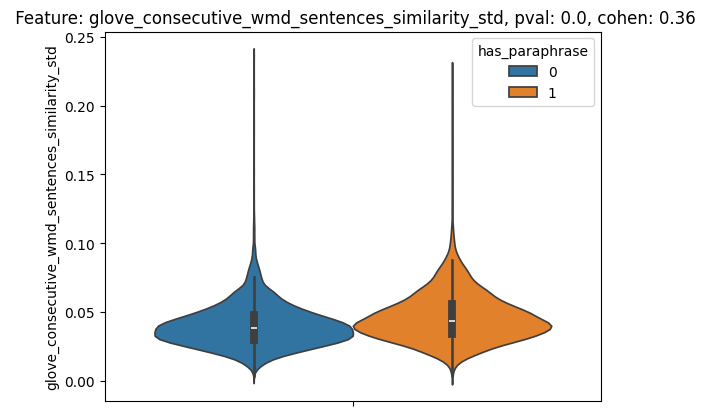

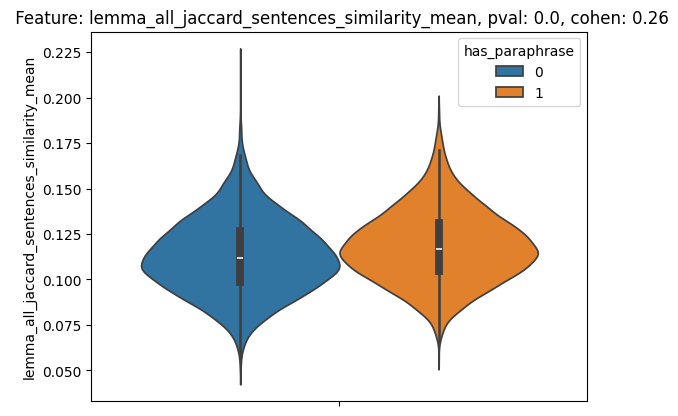

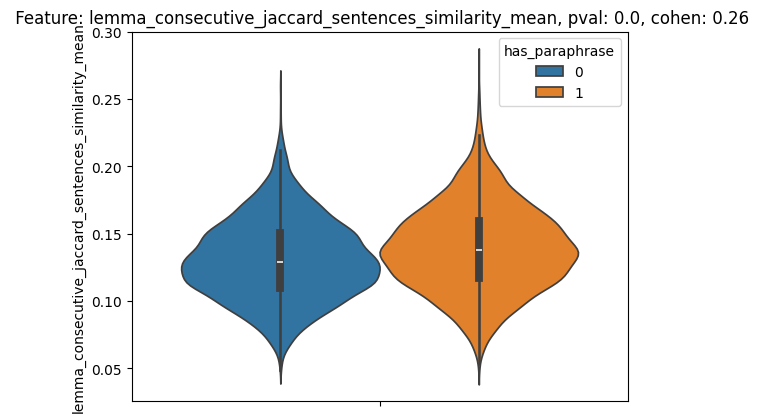

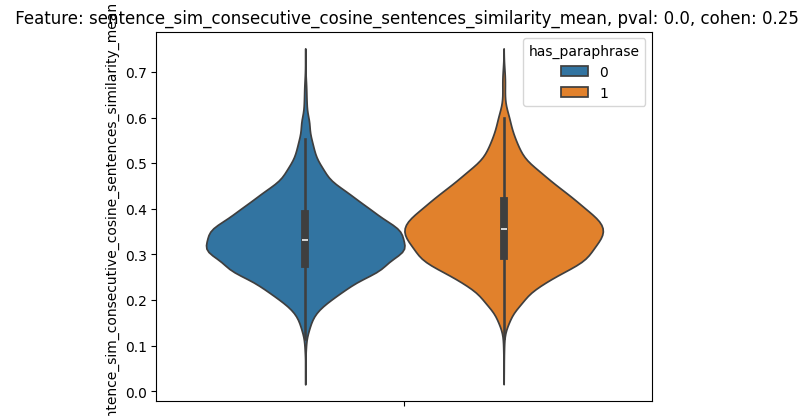

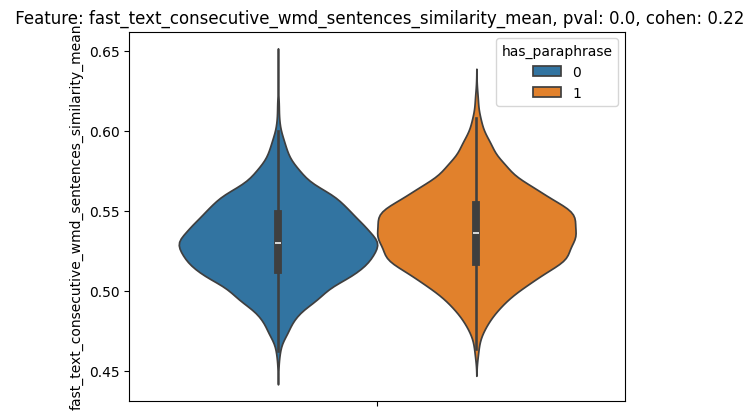

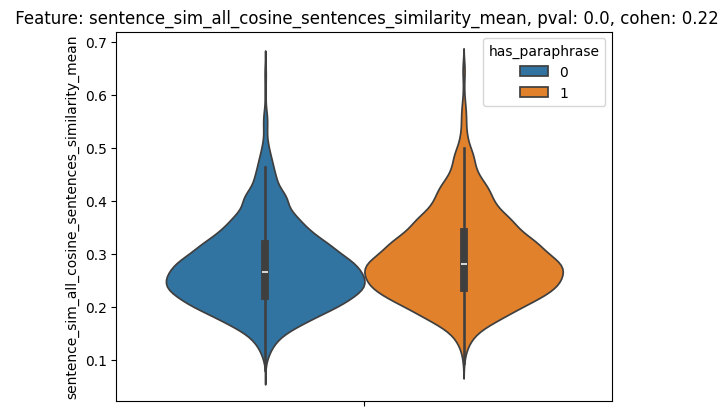

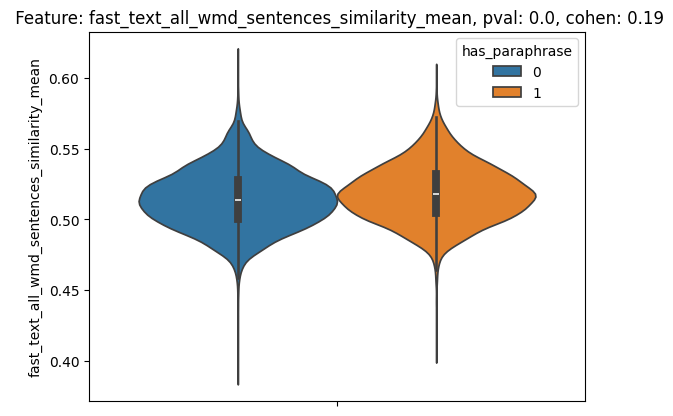

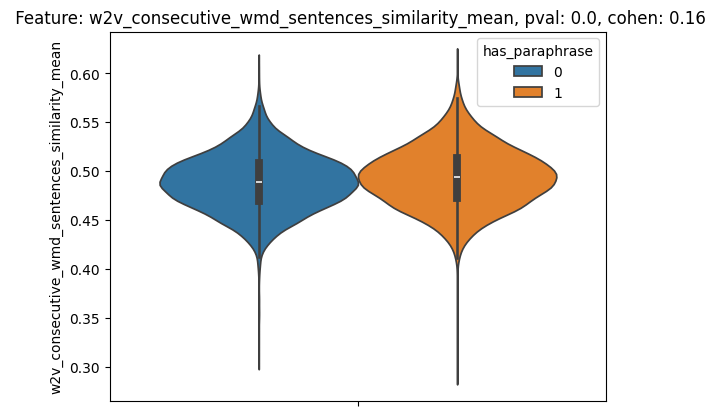

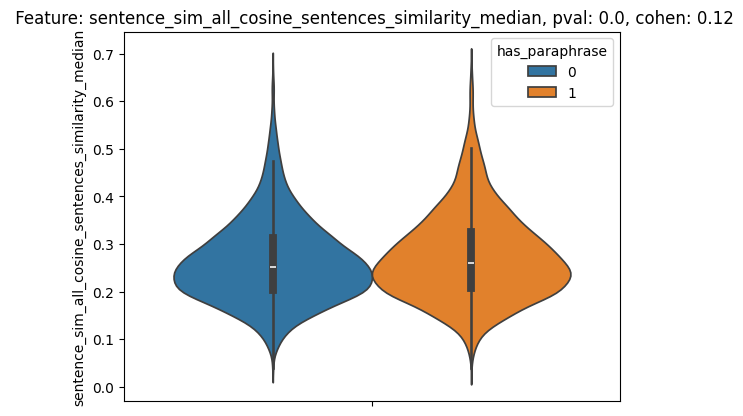

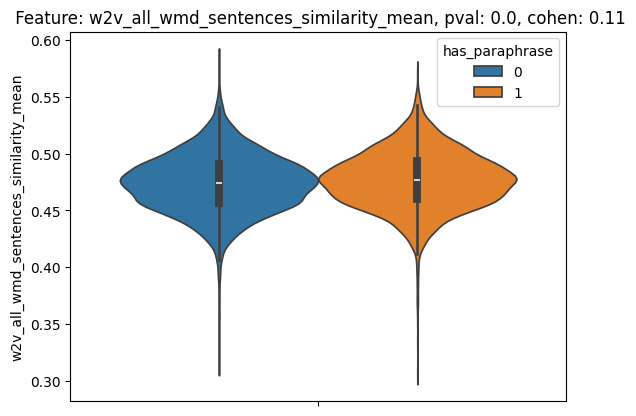

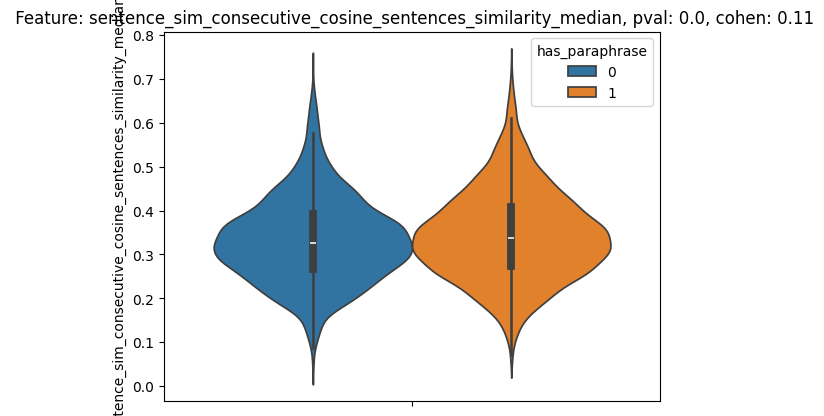

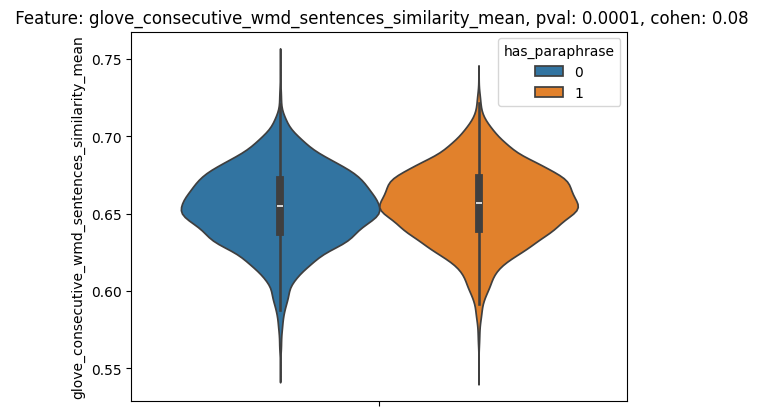

x                                                  y  \
29  has_paraphrase         lemma_all_jaccard_sentences_similarity_std   
24  has_paraphrase   sentence_sim_all_cosine_sentences_similarity_std   
11  has_paraphrase         fast_text_all_wmd_sentences_similarity_std   
5   has_paraphrase               w2v_all_wmd_sentences_similarity_std   
21  has_paraphrase  sentence_sim_consecutive_cosine_sentences_simi...   
26  has_paraphrase  lemma_consecutive_jaccard_sentences_similarity...   
13  has_paraphrase  fast_text_consecutive_wmd_sentences_similarity...   
7   has_paraphrase       w2v_consecutive_wmd_sentences_similarity_std   
15  has_paraphrase             glove_all_wmd_sentences_similarity_std   
18  has_paraphrase     glove_consecutive_wmd_sentences_similarity_std   
27  has_paraphrase        lemma_all_jaccard_sentences_similarity_mean   
25  has_paraphrase  lemma_consecutive_jaccard_sentences_similarity...   
19  has_paraphrase  sentence_sim_consecutive_cosine_sentences_simi...   
12  has_paraphrase  fast_text_consecutive_wmd_sentences_similarity...   
22  has_paraphrase  sentence_sim_all_cosine_sentences_similarity_mean   
10  has_paraphrase        fast_text_all_wmd_sentences_similarity_mean   
6   has_paraphrase      w2v_consecutive_wmd_sentences_similarity_mean   
23  has_paraphrase  sentence_sim_all_cosine_sentences_similarity_m...   
4   has_paraphrase              w2v_all_wmd_sentences_similarity_mean   
20  has_paraphrase  sentence_sim_consecutive_cosine_sentences_simi...   
16  has_paraphrase    glove_consecutive_wmd_sentences_similarity_mean   

             pval     cohen     power  
29   0.000000e+00  0.870583  1.000000  
24   0.000000e+00  0.723989  1.000000  
11   0.000000e+00  0.710019  1.000000  
5    0.000000e+00  0.590505  1.000000  
21  4.894864e-164  0.541973  1.000000  
26  2.720260e-121  0.522301  1.000000  
13  4.000530e-115  0.499596  1.000000  
7   1.128946e-104  0.433962  1.000000  
15  6.139520e-211  0.384735  1.000000  
18   3.058916e-89  0.362543  1.000000  
27   2.577842e-44  0.263873  1.000000  
25   7.903595e-43  0.258170  1.000000  
19   5.516800e-41  0.248016  1.000000  
12   2.921836e-31  0.222522  1.000000  
22   4.365607e-32  0.219424  1.000000  
10   5.741634e-24  0.193530  1.000000  
6    2.176115e-16  0.158997  1.000000  
23   1.689058e-09  0.118903  0.999940  
4    2.867502e-09  0.112279  0.999756  
20   9.605139e-09  0.111255  0.999700  
16   5.964190e-05  0.077527  0.946345

In [38]:
sim_features = not_roc_data.filter(regex='mean|std|med|mmin').columns.tolist()
stats = sa.compute_wilc_table(not_roc_data_filter, ["has_paraphrase"],sim_features, seuil=0.01)
stats = stats.sort_values(by="cohen", ascending=False)
select = stats[stats.power>0.8][['x','y',"pval",'cohen','power']]

for features in select['y'].tolist():
    sns.violinplot(data=not_roc_data_filter, hue="has_paraphrase", y=features)
    plt.title(f" Feature: {features}, pval: {select[select.y==features]['pval'].values[0].round(4)}, cohen: {select[select.y==features]['cohen'].values[0].round(2)}")
    plt.show()

select.head(len(select))

The standard deviation seams to be a good indicator of paraphrasing. The standard deviation of the similarity between all sentences is higher in text with paraphrasing. The mean is also slightly higher. Again glove is the leat interesting model.

Does this metrics can identify consecutive and  distant paraphrasing ?

In [39]:
study1 = not_roc_data[not_roc_data['has_paraphrase'] == 1]
study1['consecutive_paraphrase'] =study1.apply(lambda x: 1 if (x.clean_paraphrase_index[1]-x.clean_paraphrase_index[0])==1 else 0, axis=1)
study1["distant_paraphrase"] = study1.apply(lambda x: 1 if (x.clean_paraphrase_index[1]-x.clean_paraphrase_index[0])/x.num_sentences>0.25 else 0, axis=1)

In [40]:
target = "consecutive_paraphrase"


print(f"Total data: {len(study1)}")
print(f'{study1[target].value_counts()}')

sim_features = study1.filter(regex='mean|std|med|mmin').columns.tolist()
stats = sa.compute_wilc_table(study1, [target],sim_features, seuil=0.01)
stats = stats.sort_values(by="cohen", ascending=False)
select = stats[stats.power >0.8][['x','y',"pval",'cohen','power']]

#for features in select['y'].tolist():
#    sns.boxplot(data=study1, hue=target, y=features)
#    plt.title(f" Feature: {features}, pval: {select[select.y==features]['pval'].values[0].round(4)}, cohen: {select[select.y==features]['cohen'].values[0].round(2)}")
#    plt.show()

select

Total data: 8664
consecutive_paraphrase
0    5725
1    2939
Name: count, dtype: int64


x                                                  y  \
14  consecutive_paraphrase  fast_text_consecutive_wmd_sentences_similarity...   
27  consecutive_paraphrase  lemma_consecutive_jaccard_sentences_similarity...   
23  consecutive_paraphrase  sentence_sim_consecutive_cosine_sentences_simi...   
6   consecutive_paraphrase       w2v_consecutive_wmd_sentences_similarity_std   
20  consecutive_paraphrase     glove_consecutive_wmd_sentences_similarity_std   
25  consecutive_paraphrase  lemma_consecutive_jaccard_sentences_similarity...   
12  consecutive_paraphrase  fast_text_consecutive_wmd_sentences_similarity...   
4   consecutive_paraphrase      w2v_consecutive_wmd_sentences_similarity_mean   
21  consecutive_paraphrase  sentence_sim_consecutive_cosine_sentences_simi...   
18  consecutive_paraphrase    glove_consecutive_wmd_sentences_similarity_mean   
5   consecutive_paraphrase    w2v_consecutive_wmd_sentences_similarity_median   
22  consecutive_paraphrase  sentence_sim_consecutive_cosine_sentences_simi...   
13  consecutive_paraphrase  fast_text_consecutive_wmd_sentences_similarity...   
19  consecutive_paraphrase  glove_consecutive_wmd_sentences_similarity_median   
26  consecutive_paraphrase  lemma_consecutive_jaccard_sentences_similarity...   
7   consecutive_paraphrase  fast_text_consecutive_cosine_sentences_similar...   
8   consecutive_paraphrase  fast_text_consecutive_cosine_sentences_similar...   
0   consecutive_paraphrase   w2v_consecutive_cosine_sentences_similarity_mean   
1   consecutive_paraphrase  w2v_consecutive_cosine_sentences_similarity_me...   
9   consecutive_paraphrase  fast_text_consecutive_cosine_sentences_similar...   
24  consecutive_paraphrase   sentence_sim_all_cosine_sentences_similarity_std   

             pval     cohen     power  
14   0.000000e+00  1.441080  1.000000  
27   0.000000e+00  1.386601  1.000000  
23   0.000000e+00  1.364739  1.000000  
6    0.000000e+00  1.153514  1.000000  
20   0.000000e+00  0.988410  1.000000  
25   0.000000e+00  0.981924  1.000000  
12  3.250901e-309  0.932886  1.000000  
4   8.978096e-273  0.854554  1.000000  
21  8.091923e-246  0.796048  1.000000  
18  2.746361e-201  0.716845  1.000000  
5    1.370396e-85  0.465760  1.000000  
22   5.596344e-75  0.428282  1.000000  
13   7.825801e-70  0.414869  1.000000  
19   3.532252e-64  0.392001  1.000000  
26   2.758158e-58  0.377780  1.000000  
7    2.073402e-89  0.316454  1.000000  
8    2.288069e-75  0.294859  1.000000  
0    2.693899e-83  0.170807  1.000000  
1    1.468483e-74  0.166122  0.999999  
9    4.137433e-10  0.081150  0.841260  
24   3.368247e-06 -0.095856  0.950281

Total data: 8664
distant_paraphrase
0    5558
1    3106
Name: count, dtype: int64


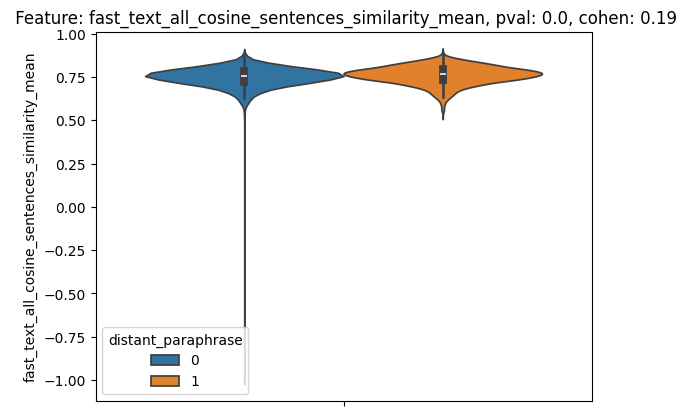

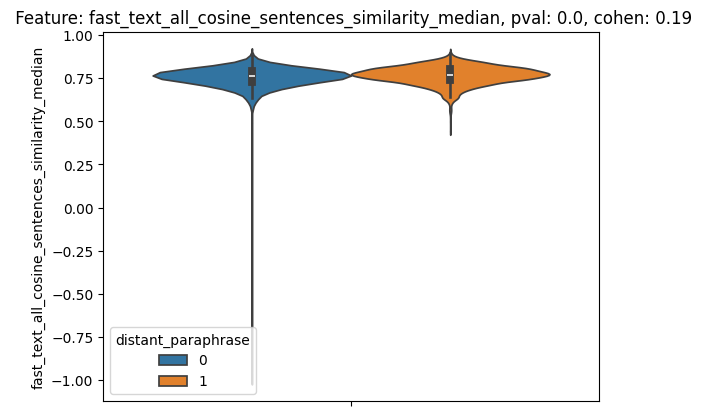

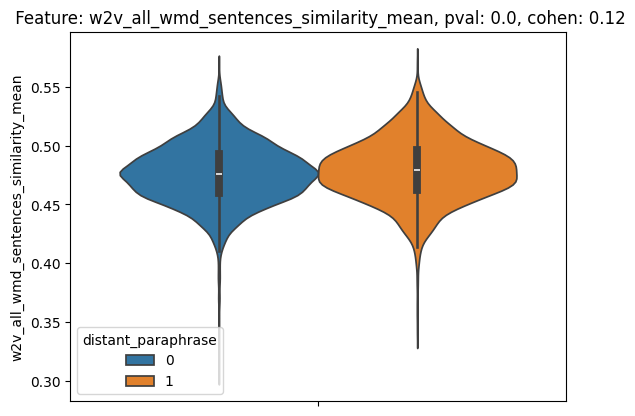

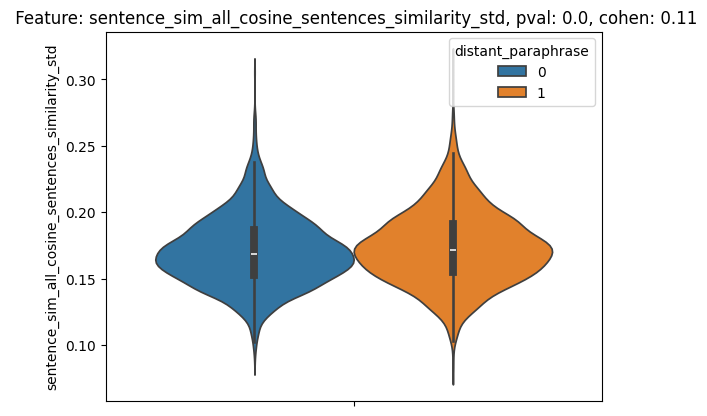

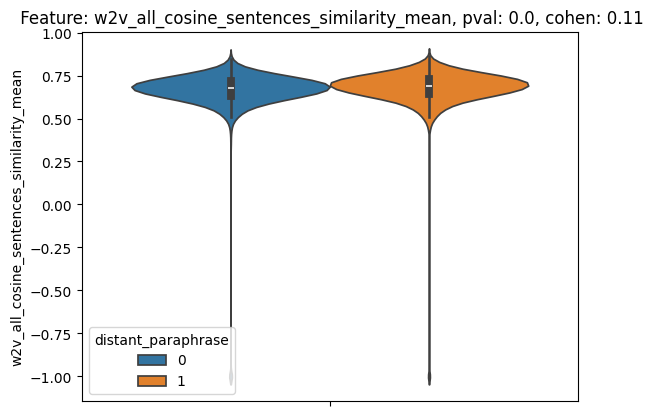

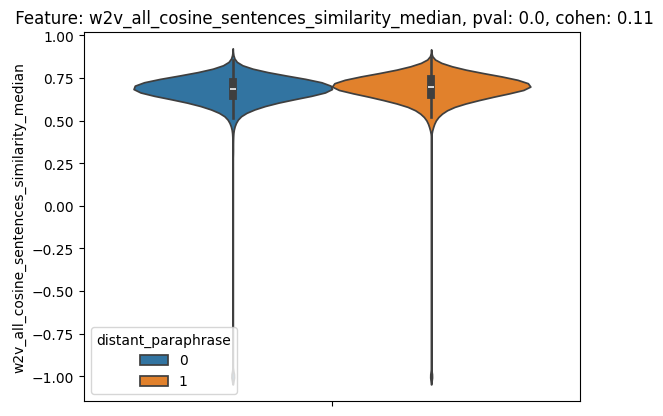

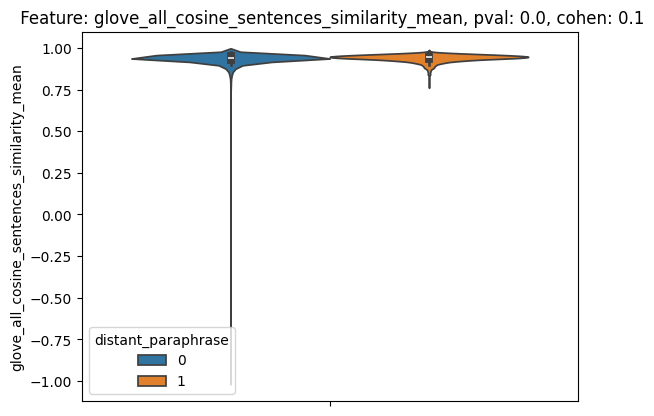

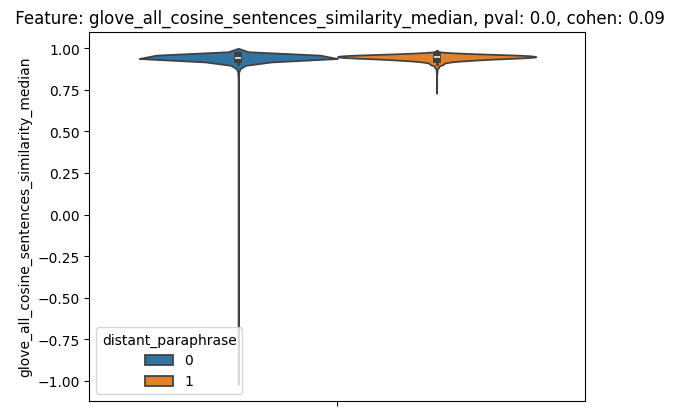

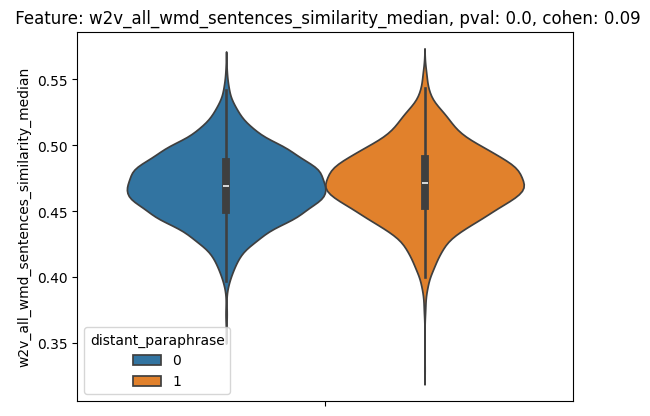

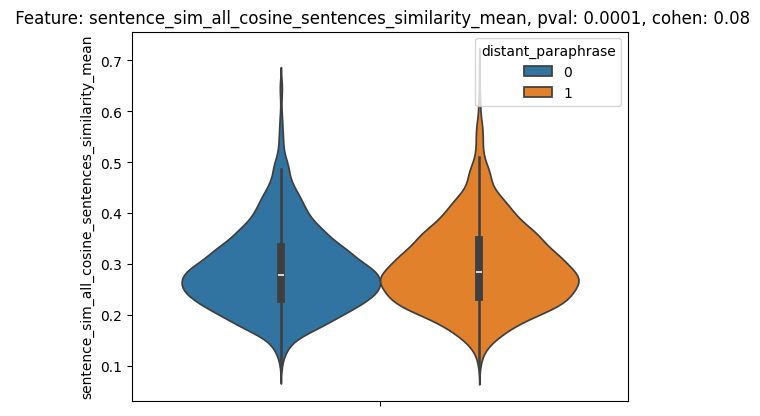

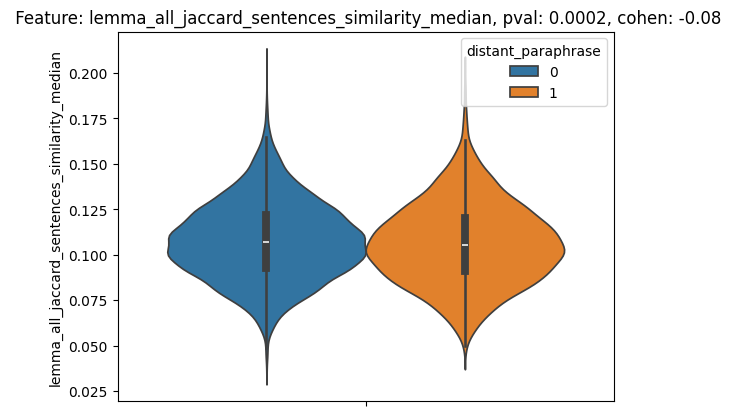

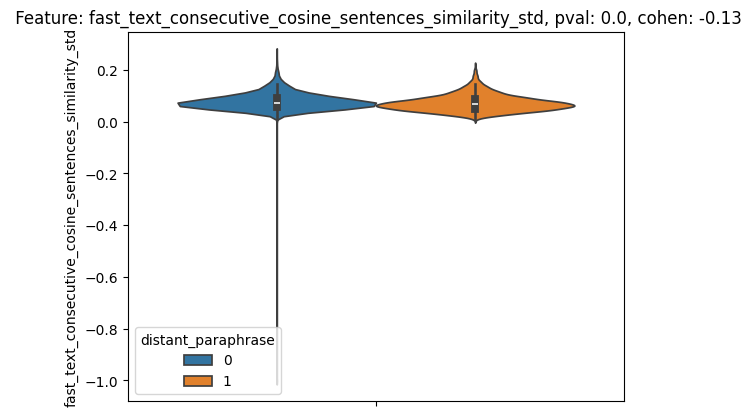

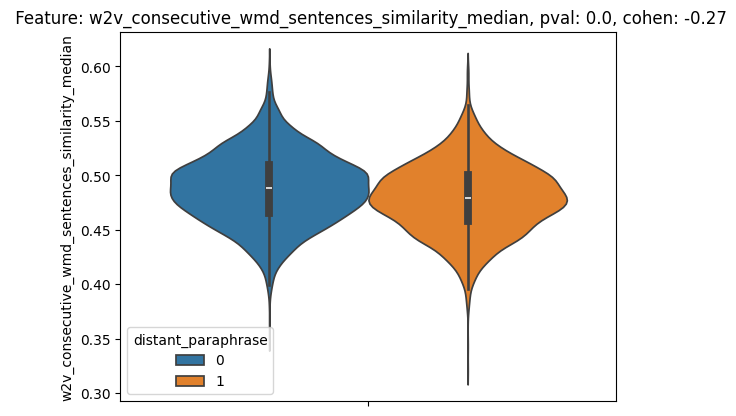

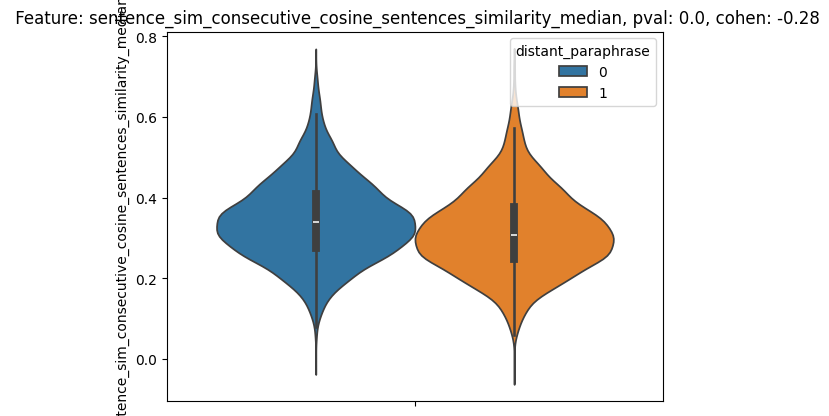

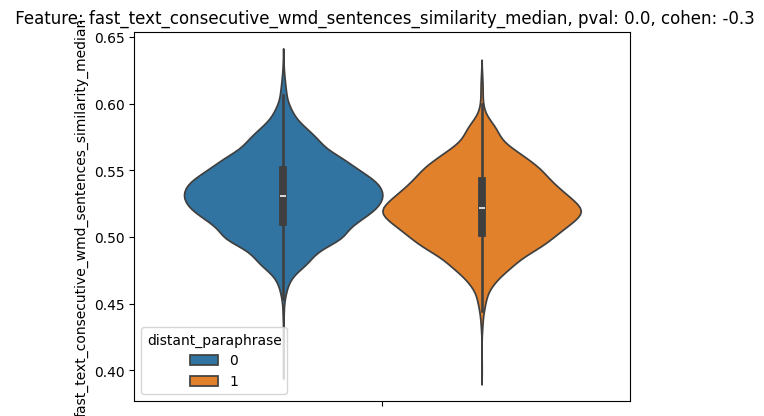

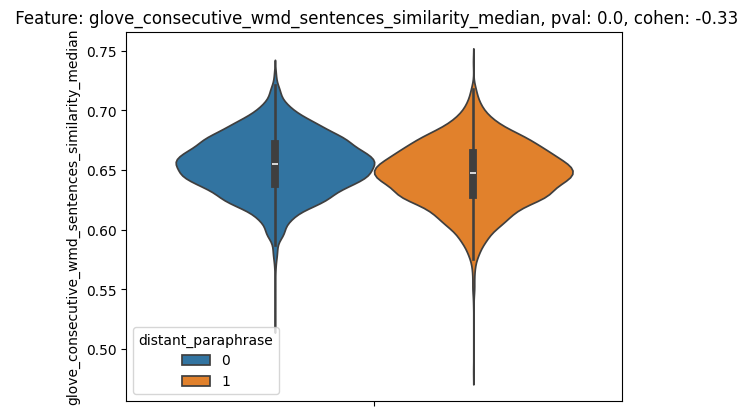

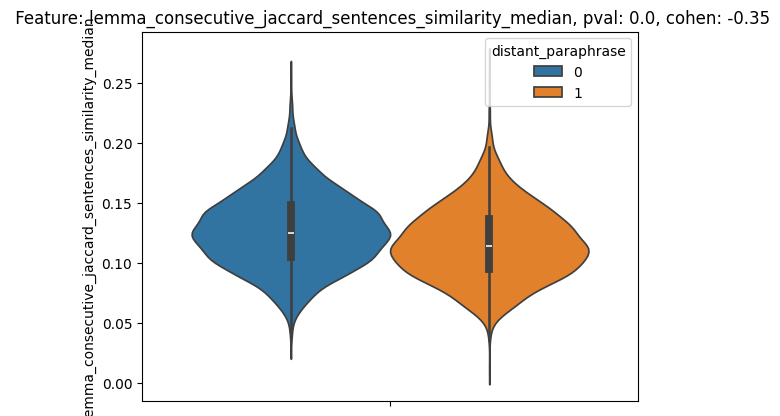

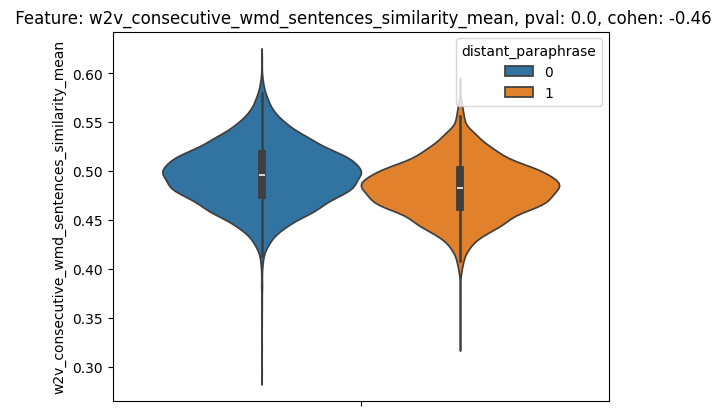

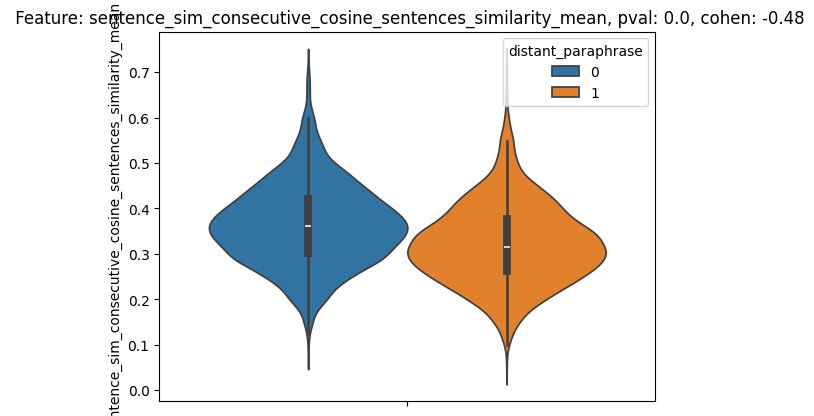

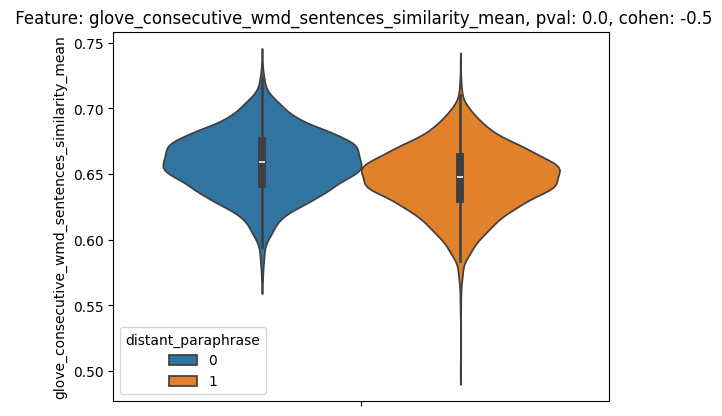

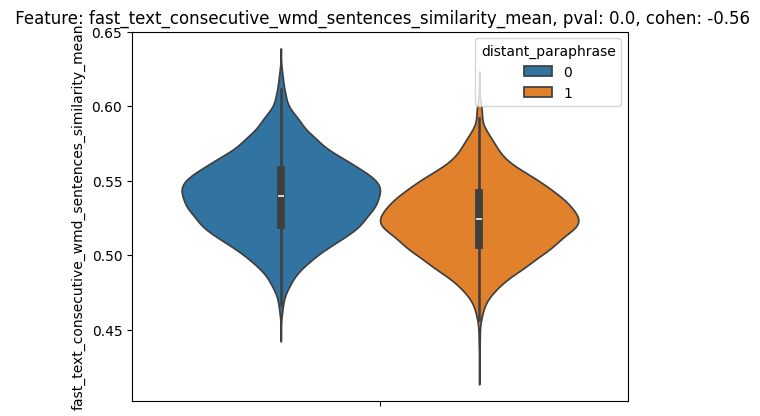

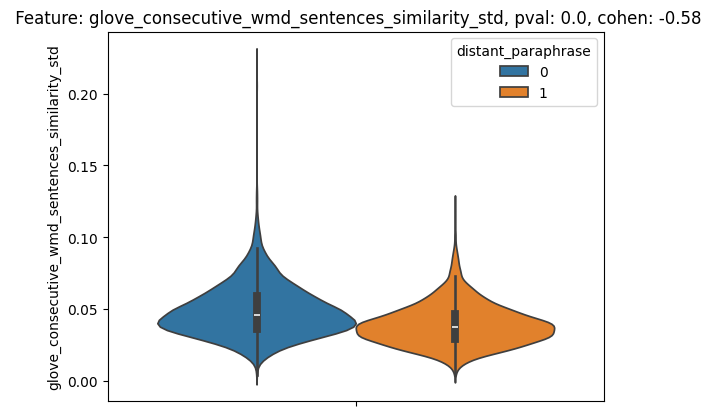

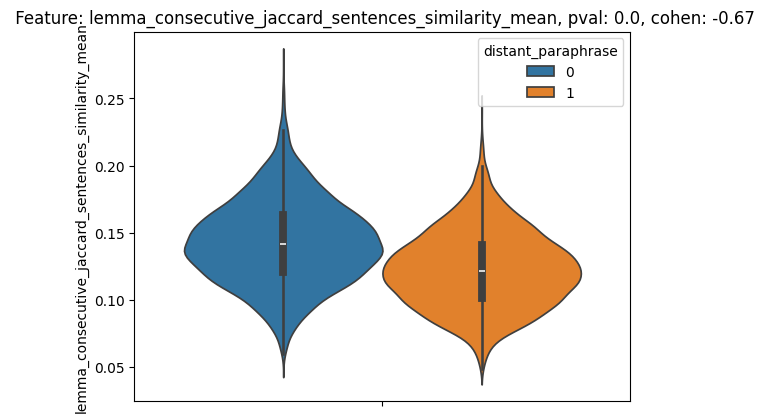

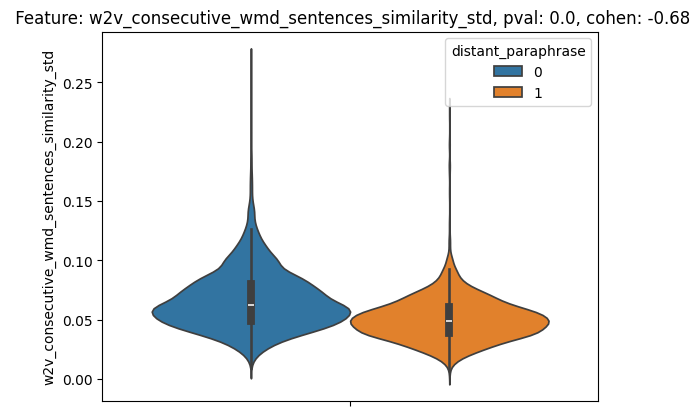

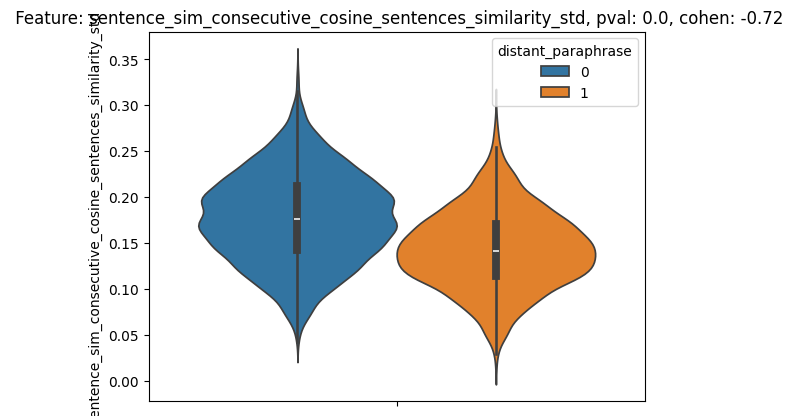

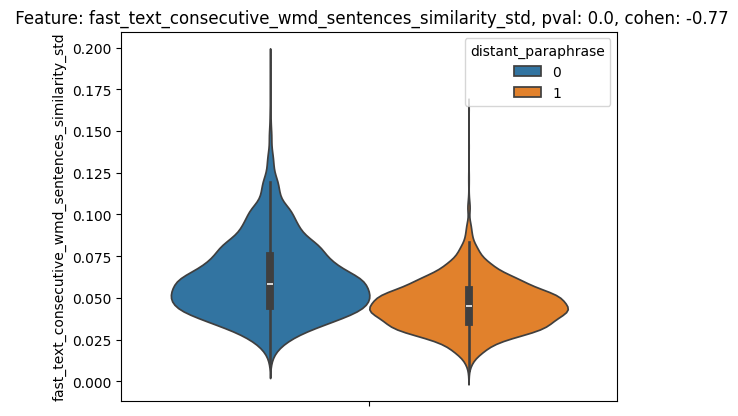

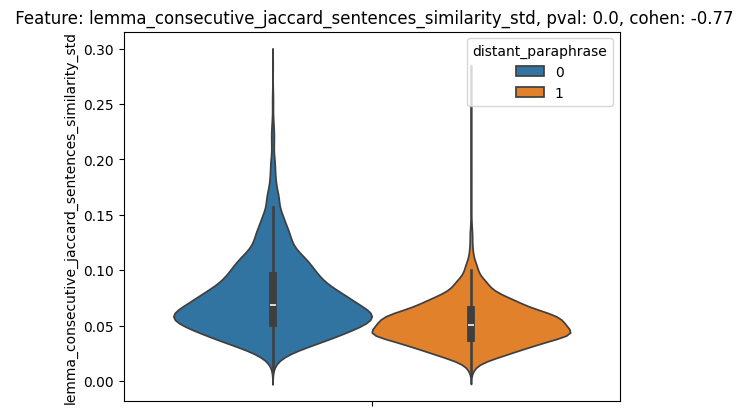

x                                                  y  \
14  distant_paraphrase     fast_text_all_cosine_sentences_similarity_mean   
15  distant_paraphrase   fast_text_all_cosine_sentences_similarity_median   
6   distant_paraphrase              w2v_all_wmd_sentences_similarity_mean   
33  distant_paraphrase   sentence_sim_all_cosine_sentences_similarity_std   
3   distant_paraphrase           w2v_all_cosine_sentences_similarity_mean   
4   distant_paraphrase         w2v_all_cosine_sentences_similarity_median   
22  distant_paraphrase         glove_all_cosine_sentences_similarity_mean   
23  distant_paraphrase       glove_all_cosine_sentences_similarity_median   
7   distant_paraphrase            w2v_all_wmd_sentences_similarity_median   
31  distant_paraphrase  sentence_sim_all_cosine_sentences_similarity_mean   
37  distant_paraphrase      lemma_all_jaccard_sentences_similarity_median   
13  distant_paraphrase  fast_text_consecutive_cosine_sentences_similar...   
9   distant_paraphrase    w2v_consecutive_wmd_sentences_similarity_median   
29  distant_paraphrase  sentence_sim_consecutive_cosine_sentences_simi...   
19  distant_paraphrase  fast_text_consecutive_wmd_sentences_similarity...   
26  distant_paraphrase  glove_consecutive_wmd_sentences_similarity_median   
35  distant_paraphrase  lemma_consecutive_jaccard_sentences_similarity...   
8   distant_paraphrase      w2v_consecutive_wmd_sentences_similarity_mean   
28  distant_paraphrase  sentence_sim_consecutive_cosine_sentences_simi...   
25  distant_paraphrase    glove_consecutive_wmd_sentences_similarity_mean   
18  distant_paraphrase  fast_text_consecutive_wmd_sentences_similarity...   
27  distant_paraphrase     glove_consecutive_wmd_sentences_similarity_std   
34  distant_paraphrase  lemma_consecutive_jaccard_sentences_similarity...   
10  distant_paraphrase       w2v_consecutive_wmd_sentences_similarity_std   
30  distant_paraphrase  sentence_sim_consecutive_cosine_sentences_simi...   
20  distant_paraphrase  fast_text_consecutive_wmd_sentences_similarity...   
36  distant_paraphrase  lemma_consecutive_jaccard_sentences_similarity...   

             pval     cohen     power  
14   1.340623e-24  0.193138  1.000000  
15   3.484102e-23  0.187093  1.000000  
6    2.004270e-07  0.115401  0.994980  
33   3.448973e-07  0.114677  0.994491  
3    2.336137e-17  0.111645  0.991953  
4    1.071581e-15  0.106593  0.985420  
22   1.059414e-19  0.102579  0.977366  
23   3.203809e-18  0.093187  0.943289  
7    3.462172e-05  0.089699  0.923262  
31   1.162337e-04  0.083468  0.874777  
37   1.844182e-04 -0.079930  0.839242  
13   4.479712e-21 -0.132072  0.999547  
9    6.147708e-31 -0.269586  1.000000  
29   4.218611e-38 -0.284018  1.000000  
19   5.319050e-39 -0.303114  1.000000  
26   1.114057e-42 -0.327392  1.000000  
35   1.265926e-53 -0.349256  1.000000  
8    9.587080e-91 -0.464858  1.000000  
28  5.433900e-101 -0.480028  1.000000  
25  6.559751e-100 -0.501267  1.000000  
18  6.203109e-125 -0.557066  1.000000  
27  2.224160e-147 -0.580059  1.000000  
34  3.212417e-177 -0.667790  1.000000  
10  3.241831e-209 -0.682577  1.000000  
30  2.964274e-204 -0.722434  1.000000  
20  5.411241e-234 -0.767830  1.000000  
36  2.745509e-257 -0.768309  1.000000

In [41]:
target = "distant_paraphrase"


print(f"Total data: {len(study1)}")
print(f'{study1[target].value_counts()}')

sim_features = study1.filter(regex='mean|std|med|mmin').columns.tolist()
stats = sa.compute_wilc_table(study1, [target],sim_features, seuil=0.01)
stats = stats.sort_values(by="cohen", ascending=False)
select = stats[stats.power >0.8][['x','y',"pval",'cohen','power']]

for features in select['y'].tolist():
    sns.violinplot(data=study1, hue=target, y=features)
    plt.title(f" Feature: {features}, pval: {select[select.y==features]['pval'].values[0].round(4)}, cohen: {select[select.y==features]['cohen'].values[0].round(2)}")
    plt.show()

select


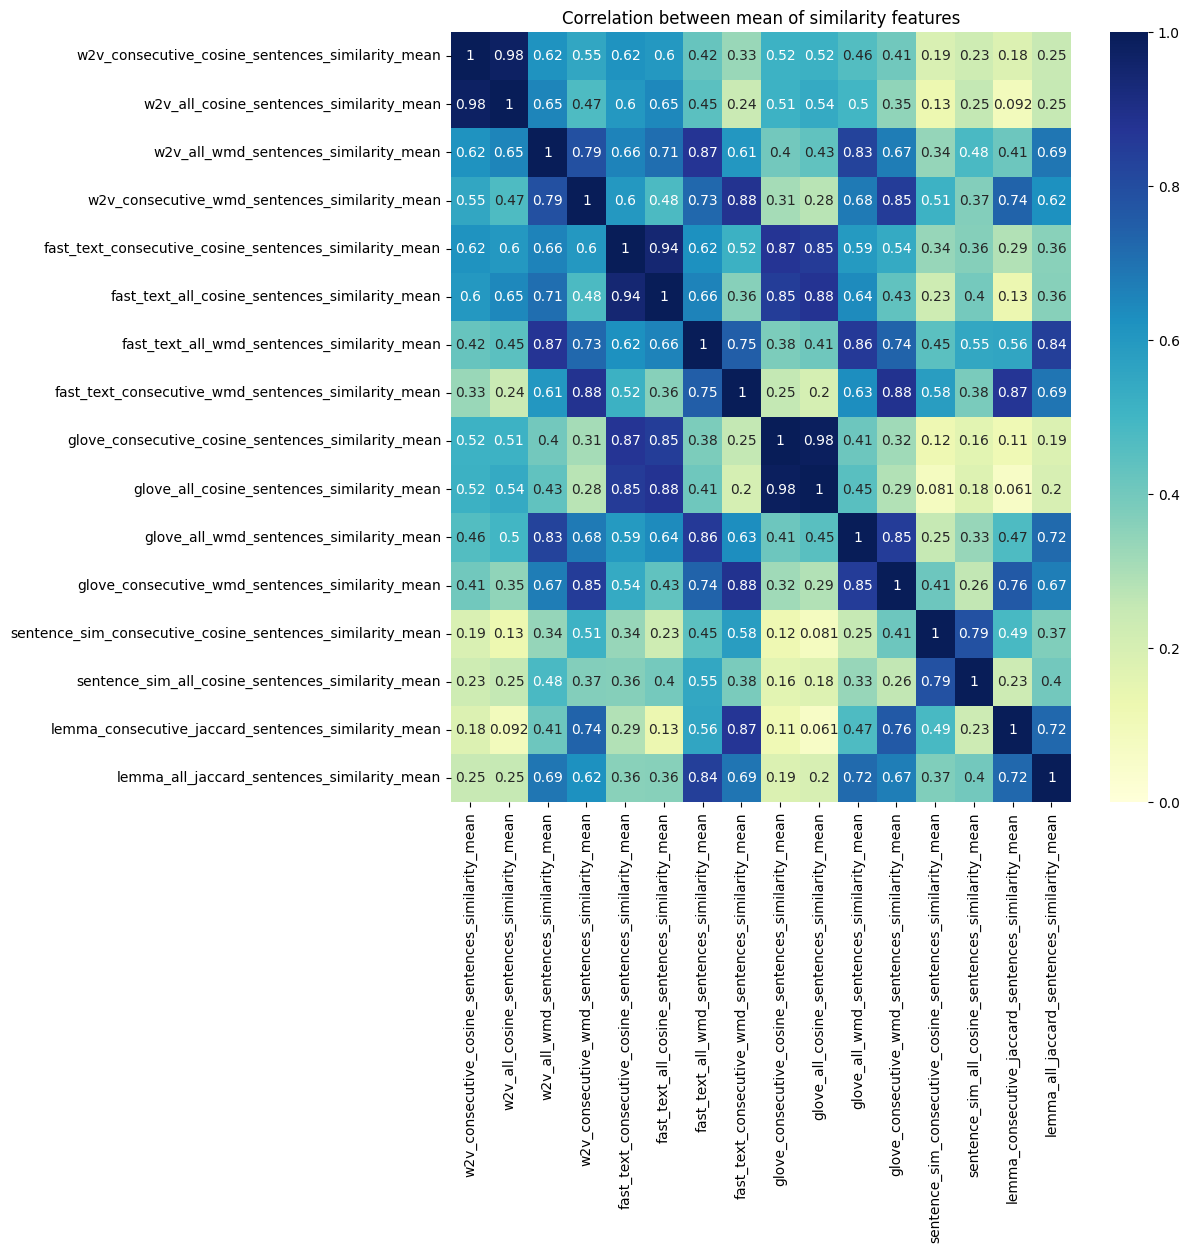

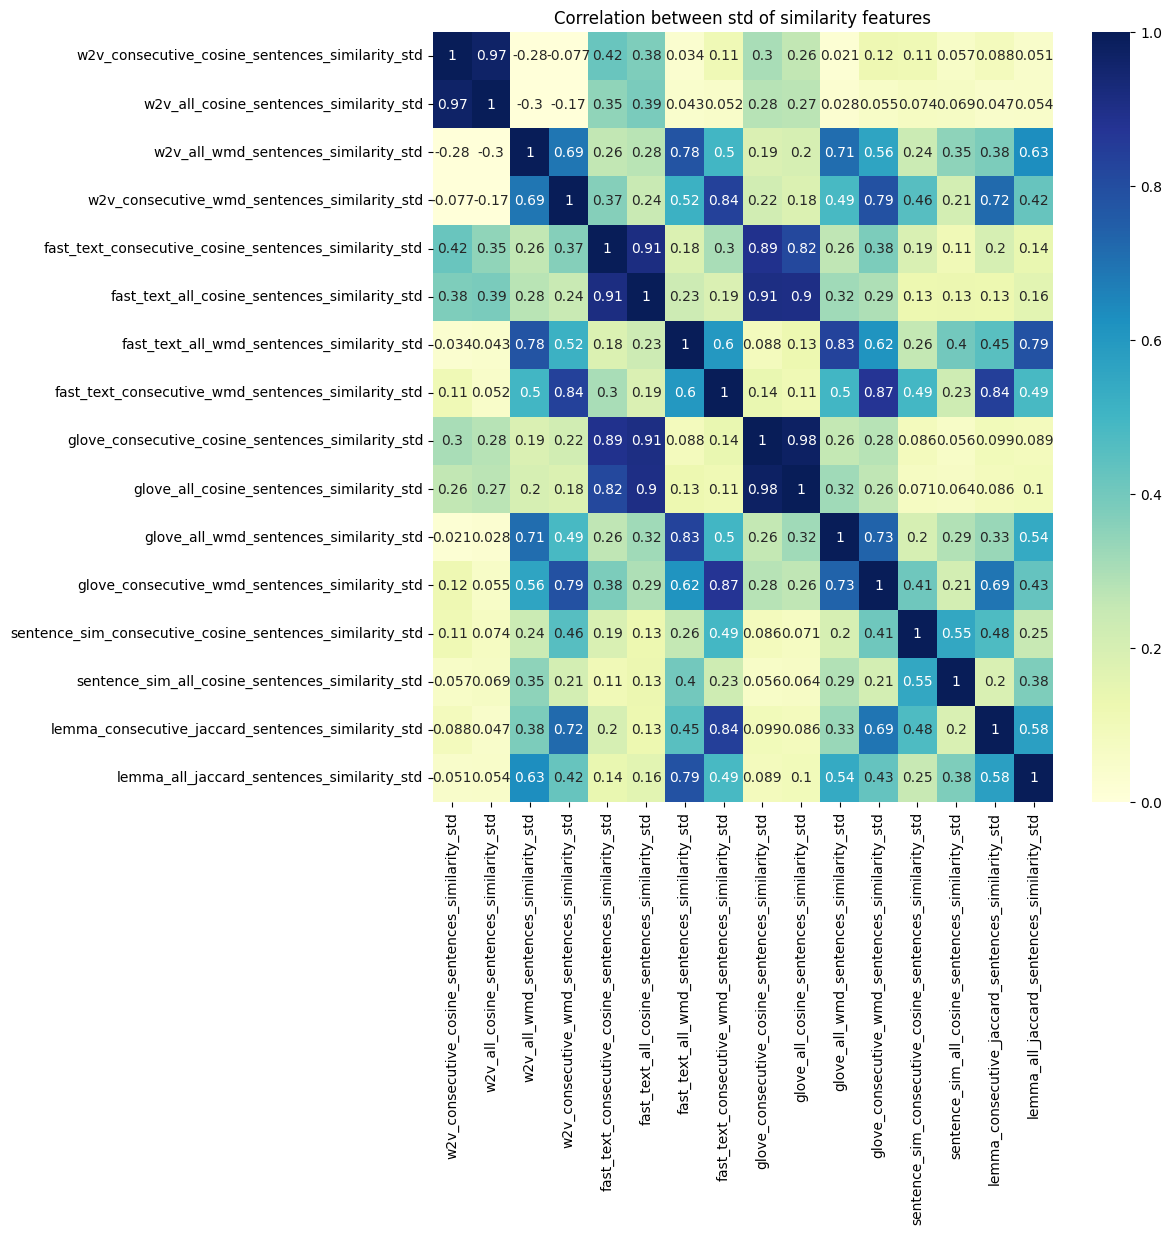

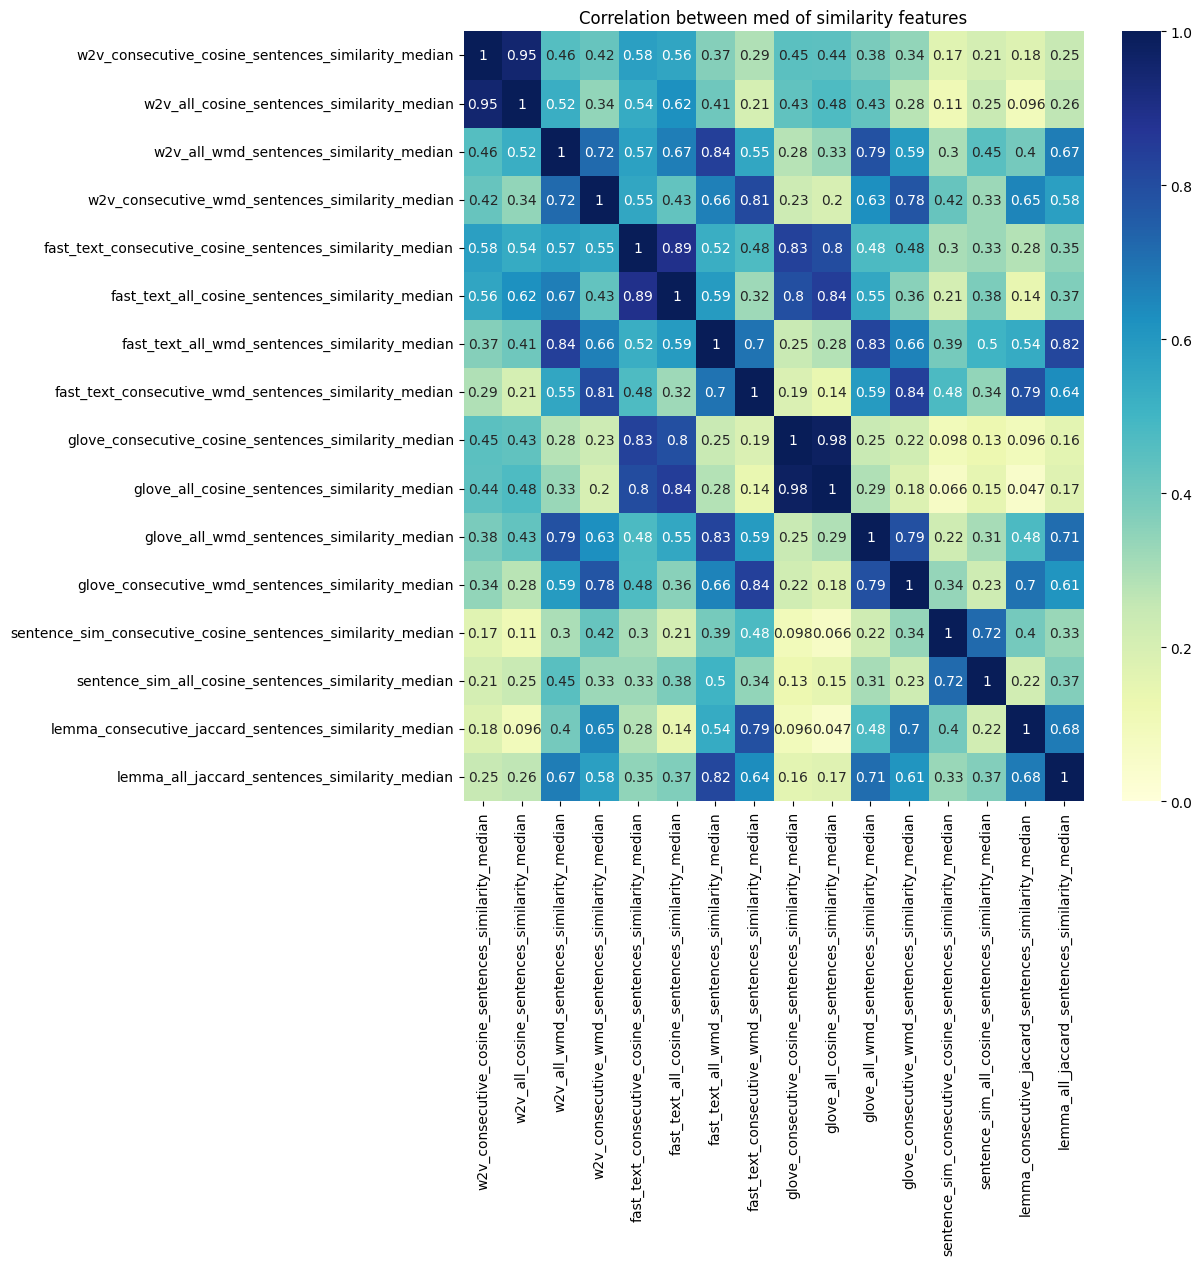

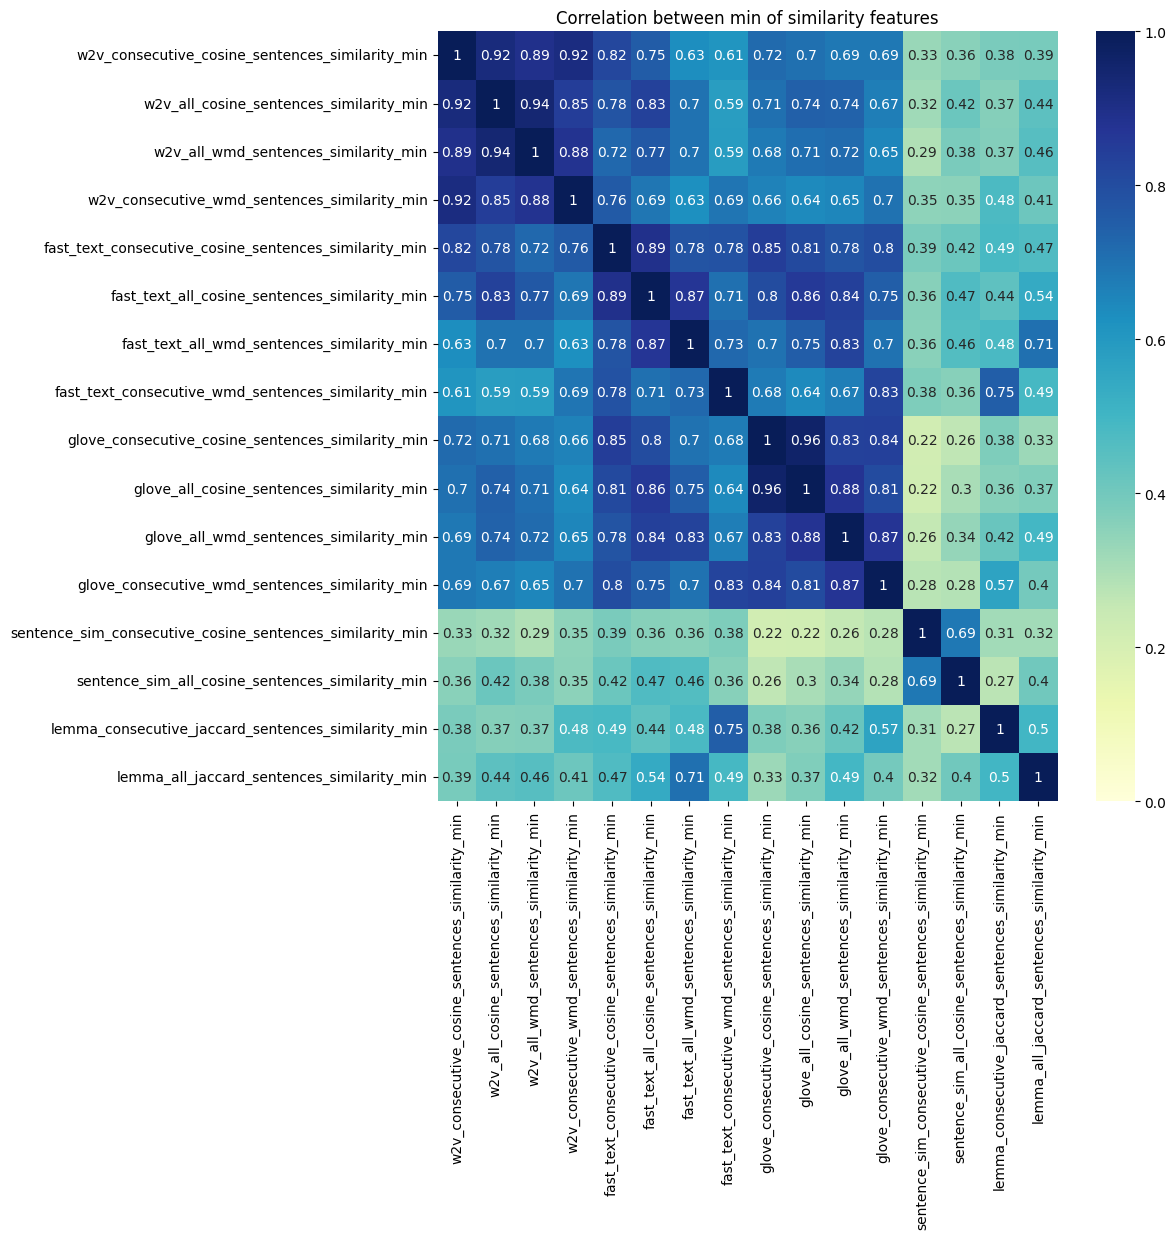

In [42]:
for stats in ['mean','std','med','min']:
    sim_features = study1.filter(regex=stats).columns.tolist()
    c = not_roc_data[sim_features].corr()
    plt.figure(figsize=(10,10))
    sns.heatmap(c,vmin=0, vmax=1, annot=True, cmap="YlGnBu")
    plt.title(f"Correlation between {stats} of similarity features")

This features are also significantly different between the two categories. 
For instance, The standard deviation of consecutive sentences is lower when the paraphrasing is distant. The mean of the word mover distance over all sentences is higher in the distant paraphrasing.

The Jaccard similarity index is very associated with the paraphrasing, that means the praphrased sentences have a lot of words in common with the original sentence. We want to identify the semantic repetition, thus, we want to exclude the paraphrase that are too close in a lexical point of view.

In [43]:
import textdistance
import spacy
nlp = spacy.load('en_core_web_sm')

def compute_jaccard(s1,s2):
    lemma_list_1 = [token.lemma_.lower() for token in nlp(s1)]
    lemma_list_2 = [token.lemma_.lower() for token in nlp(s2)]
    para_sim = textdistance.jaccard.similarity(lemma_list_1, lemma_list_2)

    return para_sim

def compute_jaccard_para_sim(x):
    sentences = x.sentences
    sentences = [s.strip() for s in sentences]
    para_index = x.clean_paraphrase_index
    
    if len(para_index) == 2:
        try : 
            para_sentences = [sentences[para_index[0]], sentences[para_index[1]]]
            para_sim = compute_jaccard(para_sentences[0], para_sentences[1])
        except:
            para_sim = -1
            
    else:
        para_sim = -1
    return para_sim

not_roc_data['jaccard_para_sim'] = not_roc_data.apply(lambda x: compute_jaccard_para_sim(x), axis=1)


In [44]:
sns.histplot(data = study1, x = 'jaccard_para_sim', hue  = "paraphrase_model", kde = True)

ValueError: Could not interpret value `jaccard_para_sim` for `x`. An entry with this name does not appear in `data`.

The IBM paraphrasing process produce paraphrase that are lexicaly closer that GPT3.5. We want to see how the features  identify the difficult paraphrase, so we will considered as difficult the paraphrase with jaccard similarity index under the median of our dataset.

In [ ]:
jaccard_median = study1['jaccard_para_sim'].median()
not_roc_data['has_semantic repetition'] = not_roc_data['jaccard_para_sim'].apply(lambda x: 1 if 0< x < jaccard_median else  0)
print(jaccard_median)

0.3333333333333333


In [ ]:
semantic_repetition_data = not_roc_data[(not_roc_data['has_semantic repetition'] == 1) | (not_roc_data['has_paraphrase'] == 0)]

semantic_repetition_data['has_paraphrase'].value_counts()

has_paraphrase
1    2680
0     786
Name: count, dtype: int64

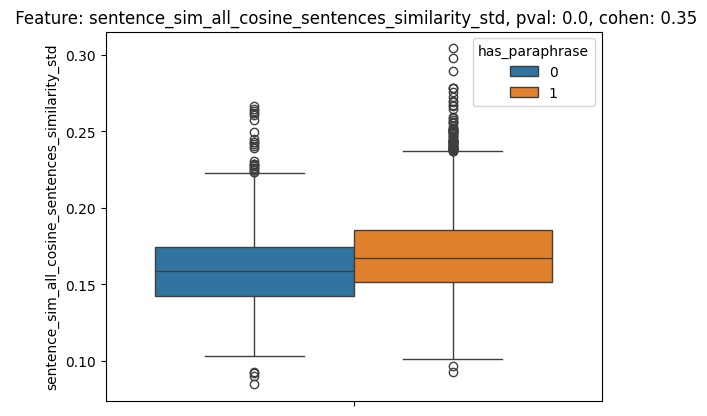

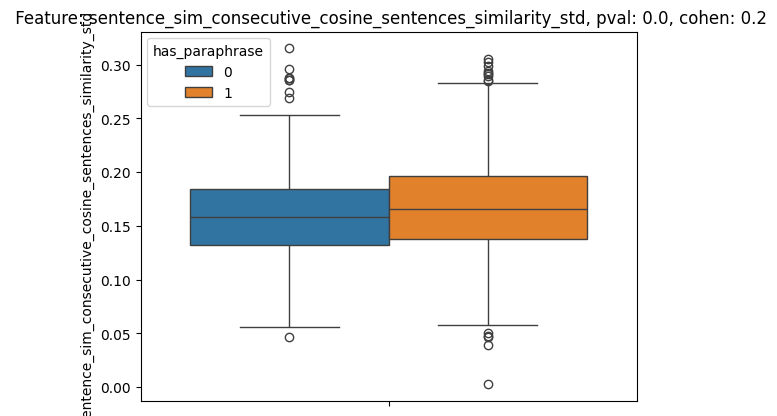

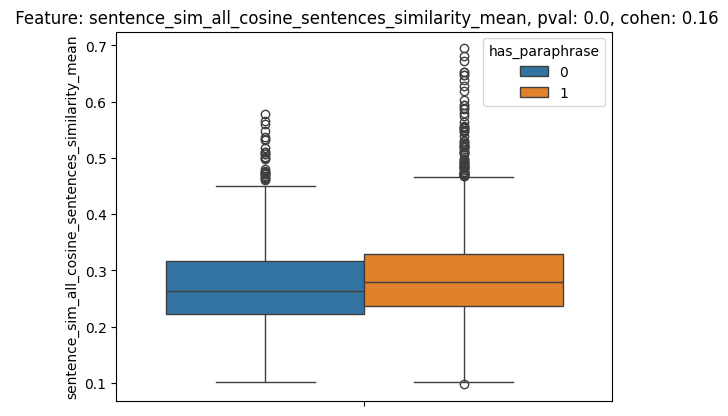

x                                                  y  \
5  has_paraphrase   sentence_sim_all_cosine_sentences_similarity_std   
2  has_paraphrase  sentence_sim_consecutive_cosine_sentences_simi...   
3  has_paraphrase  sentence_sim_all_cosine_sentences_similarity_mean   

           pval     cohen     power  
5  7.651644e-19  0.348406  1.000000  
2  8.921299e-07  0.203904  0.992828  
3  1.479759e-06  0.164292  0.929553

In [ ]:
sim_features = not_roc_data.filter(regex='mean|std|med|mmin').columns.tolist()
stats = sa.compute_wilc_table(semantic_repetition_data, ["has_paraphrase"],sim_features, seuil=0.01)
stats = stats.sort_values(by="cohen", ascending=False)
select = stats[stats.power>0.7][['x','y',"pval",'cohen','power']]
for features in select['y'].tolist():
    sns.boxplot(data=semantic_repetition_data, hue="has_paraphrase", y=features)
    plt.title(f" Feature: {features}, pval: {select[select.y==features]['pval'].values[0].round(4)}, cohen: {select[select.y==features]['cohen'].values[0].round(2)}")
    plt.show()
select.head(len(select))

In [ ]:
## Does the paraphrasing process involved lexical repetition ?


When removing the paraphrase that are too close in a lexical point of view, the only  features that are still significantly different between has and has not paraphrase are the features based on sentence Embeddings.